# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Домашнее задание 4. Линейные модели
### Мягкий дедлайн --- 25.11 23:59
### Жесктий дедлайн --- 30.11 16:59

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.


В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека `scipy.stats`. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook c:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается **в 10 баллов**.

In [2]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

В учебных целях в первой задаче запрещено использовать готовые реализации линейной регрессии (например, из пакета *scikit-learn*).

## Задача 1 (10 баллов)

На полигоне испытывается новая модель трамвая. В одном из испытании работы двигателя проверяется, что движение трамвая равномерно. Для проведения теста на трамвай установлен датчик, посекундно измеряющий пройденное расстояние.

Записи датчика можно описать такой моделью:

 $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$

где $X_i$ --- расстояние, которое проехал трамвай за $i$ секунд. В модели $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ --- ошибка отсчета времени. Все ошибки $\varepsilon_i^t$ независимы и распределены по закону $N(0, \sigma^2)$.

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени.

Данные возьмите из файла Regression.csv. Сделайте выводы.

### Решение

Загрузим датасет, содержащий показания датчика.

In [3]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1pJSA_OGMHu2Ks__Wqf0digi3RAz7Wg7J

exec: Failed to execute process '/Users/aitore_04/Desktop/all_stuff/материалы мфти/третий_курс_мат/python_prac/myenv/bin/pip': The file specified the interpreter '/Users/aitore_04/Desktop/python_prac/myenv/bin/python3.12', which is not an executable command.
fish: No matches for wildcard 'https://drive.google.com/uc?id=1pJSA_OGMHu2Ks__Wqf0digi3RAz7Wg7J'. See `help wildcards-globbing`.
gdown https://drive.google.com/uc?id=1pJSA_OGMHu2Ks__Wqf0digi3RAz7Wg7J
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^


Датасет состоит из 1000 измерений. По смыслу средняя скорость имеет размерность метры в секунду.

In [4]:
X = np.genfromtxt('regression.csv')
print('Размер датасета:', X.shape)
print('Средняя скорость:', X[-1] / X.shape[0])

Размер датасета: (1000,)
Средняя скорость: 12.0408175


Визуализируйте выборку и сделайте выводы о том, верно ли что линейная регрессионная модель имеет смысл

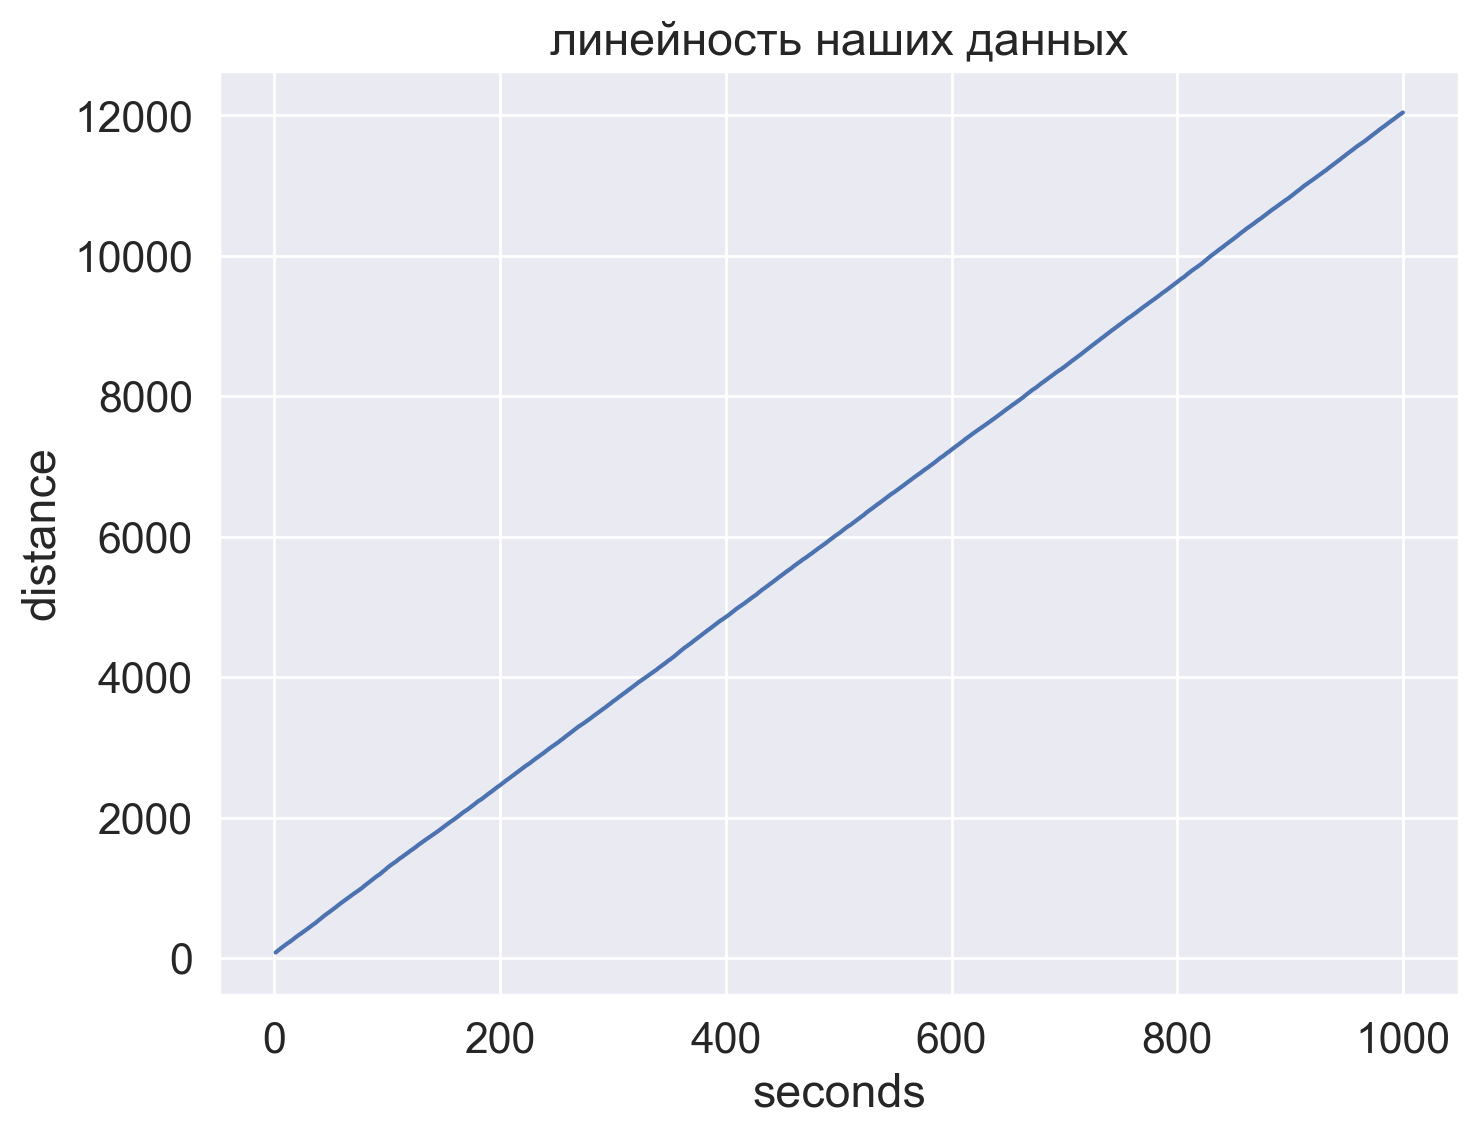

In [5]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=[8, 6])
    grid = np.arange(1, X.size + 1)
    plt.plot(grid, X)
    plt.title("линейность наших данных")
    plt.xlabel("seconds")
    plt.ylabel("distance")
    plt.show()

Выборка и вправду ведет себя линейным образом, на графике видны не ровности, но это все изза незначительных погрешностей

#### 1. Сведите задачу к гауссовской линейной модели (определения брать из основного курса)

по разборам с семинаров рассмотрим массив разностей данных, так мы сведем нашую модель к линейной регресионной (гауссовское)нормальной модели

In [6]:
# тут можете пересчитать выборку, если потребуется
my_list = [X[0]]
difference = np.diff(X)
my_list.extend(difference)
sample = np.array(my_list)

In [7]:
N = sample.size

#### 2. Найдите оценку параметров

Укажите, чему равна матрица (Z в терминах методички) в задаче:

И найдите параметры $\beta_1$, $\beta_2$

##### найдем оценку параметров по методу наименьших квадратов 

In [8]:
Z = np.vstack(([1,0], np.tile([0,1], (N - 1, 1))))
theta_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ sample
print(f"B1 = {round(theta_hat[0], 2)}")
print(f"B2 = {round(theta_hat[1], 2)}")

B1 = 82.01
B2 = 11.97


*Ошибкой* или *остатком* называют разность между наблюдаемым значением целевой величины и предсказанием модели на основе соответствующих признаков. Проверьте, насколько точна модель при помощи подсчёта ошибок. Выведите сами ошибки на график и проанализируйте его.

In [9]:
bugs_array = sample - (Z @ theta_hat)

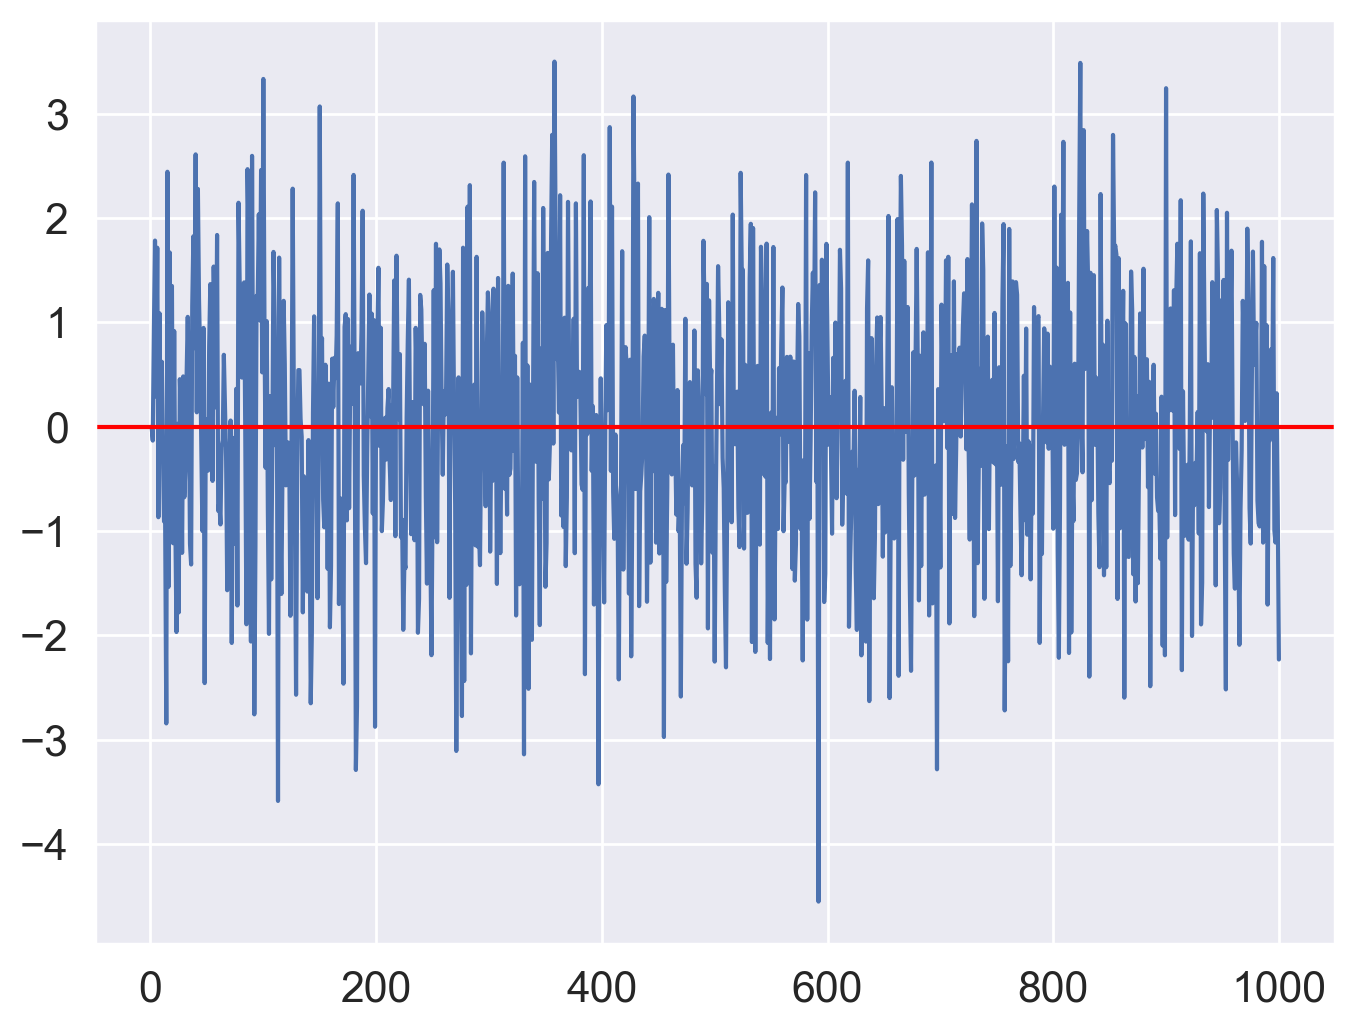

In [10]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (8, 6))
    temp_grid = np.arange(1, N + 1)
    plt.plot(temp_grid, bugs_array)
    plt.axhline(0, color = "red")

Проверьте, что ошибка нормальна. Для этого можно использовать QQ-plot. Если хотите, можете использовать критерии нормальности

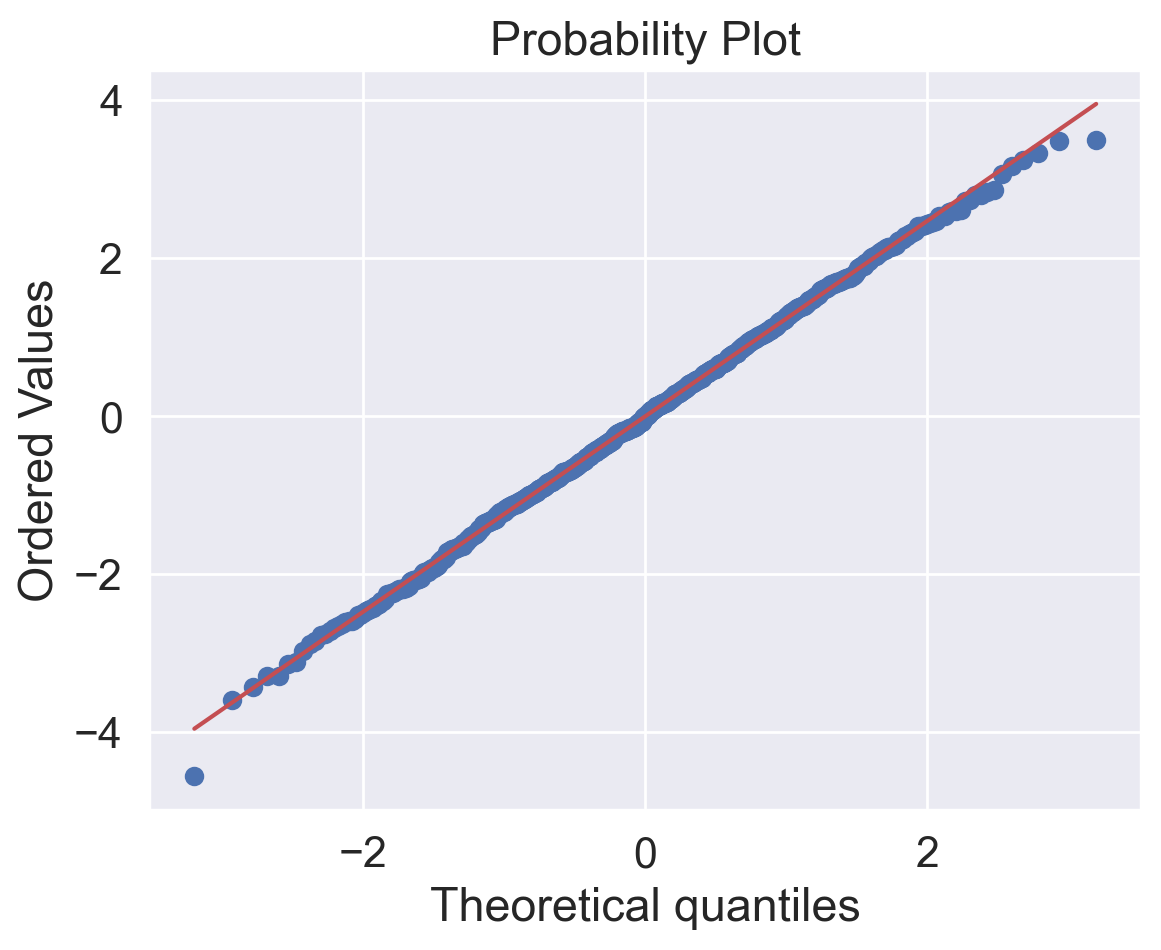

In [11]:
with sns.axes_style("darkgrid"):
    sps.probplot(bugs_array, dist=sps.norm(loc = 0, scale = 1), plot = plt)


как мы видим, ошибки при вычислениях правда распределены по нормальному распределению

Бонусная часть (+5 баллов):

Возможно измерения в задаче содержат разные аномалии, что плохо скажется на оценке наименьших квадратов. Попробуйте применить знания из предыдущей домашки о робастных оценках и построить оценку с BP выше нуля. Такие методы называются "робастной регрессией", но определение M-оценки в них то же, что и в обычной робастной статистике.

#### 3. Оцените дисперсию ошибки показаний датчика.

Найдите оценку дисперсии ошибка приращения расстояния $\varepsilon_i$. По ней найдите оценку дисперсию ошибки отсчёта времени $\varepsilon_i^t$.

In [12]:
sigma_hat_dist = (bugs_array.T @ bugs_array) /(N - 2)
sigma_hat_time = sigma_hat_dist / theta_hat[1]**2

print(f"дисперсия расстояний = {round(sigma_hat_dist, 2)}")
print(f"дисперсия времени = {round(sigma_hat_time, 2)}")

дисперсия расстояний = 1.53
дисперсия времени = 0.01


#### 4. Измерьте качество модели

Посчитаем коэфицент детерминации $R^2$

In [13]:
Y = sample
X = Z @ theta_hat

In [14]:
sigma_t = np.mean((Y - np.mean(Y)).T @ (Y - np.mean(Y)))
sigma = np.mean((X - Y).T @ (X - Y))

print(f"R^2 = {1 - sigma/sigma_t}")


R^2 = 0.7629764560832568


**Вывод:** модель вышла неплохой так как коэфицент детерминации >= 0.5, но и до 0.8 не дотягивает

## Задача 2 (5 баллов)

Непараметрическая регрессия и метод Надарая-Ватсона.

Иногда вытаскивать информативные признаки из данных сложно, а регрессию делать хочется. Тогда можно построить нечто похожее на ядерную оценку плотности, но для регрессионной задачи. Она основана на вычислении значения в новой точке по значениям в соседних точках (похожее Вы видели на курсе машинного обучения, но для классификации и без статистики).

Изучите формулу Надарая-Ватсона из статьи на википедии: https://en.wikipedia.org/wiki/Kernel_regression

1) Сгенерируйте выборку для линейной регрессии руками (использовать реальные данные может быть нецелесообразно из-за проблем с визуализацией результата и проклятия размерностей).

Пусть в модели будет одна фича $x$ и по ней вычисляется отклик $y = ax + b + \varepsilon$, где ошибка независима и нормальна, а параметры $a$ и $b$ выберите сами.

In [15]:
a = 2
b = 3
N = 1000

In [16]:
eps = sps.norm.rvs(size = N)
x = np.linspace(-5, 5, N)
y = x * a + b + eps

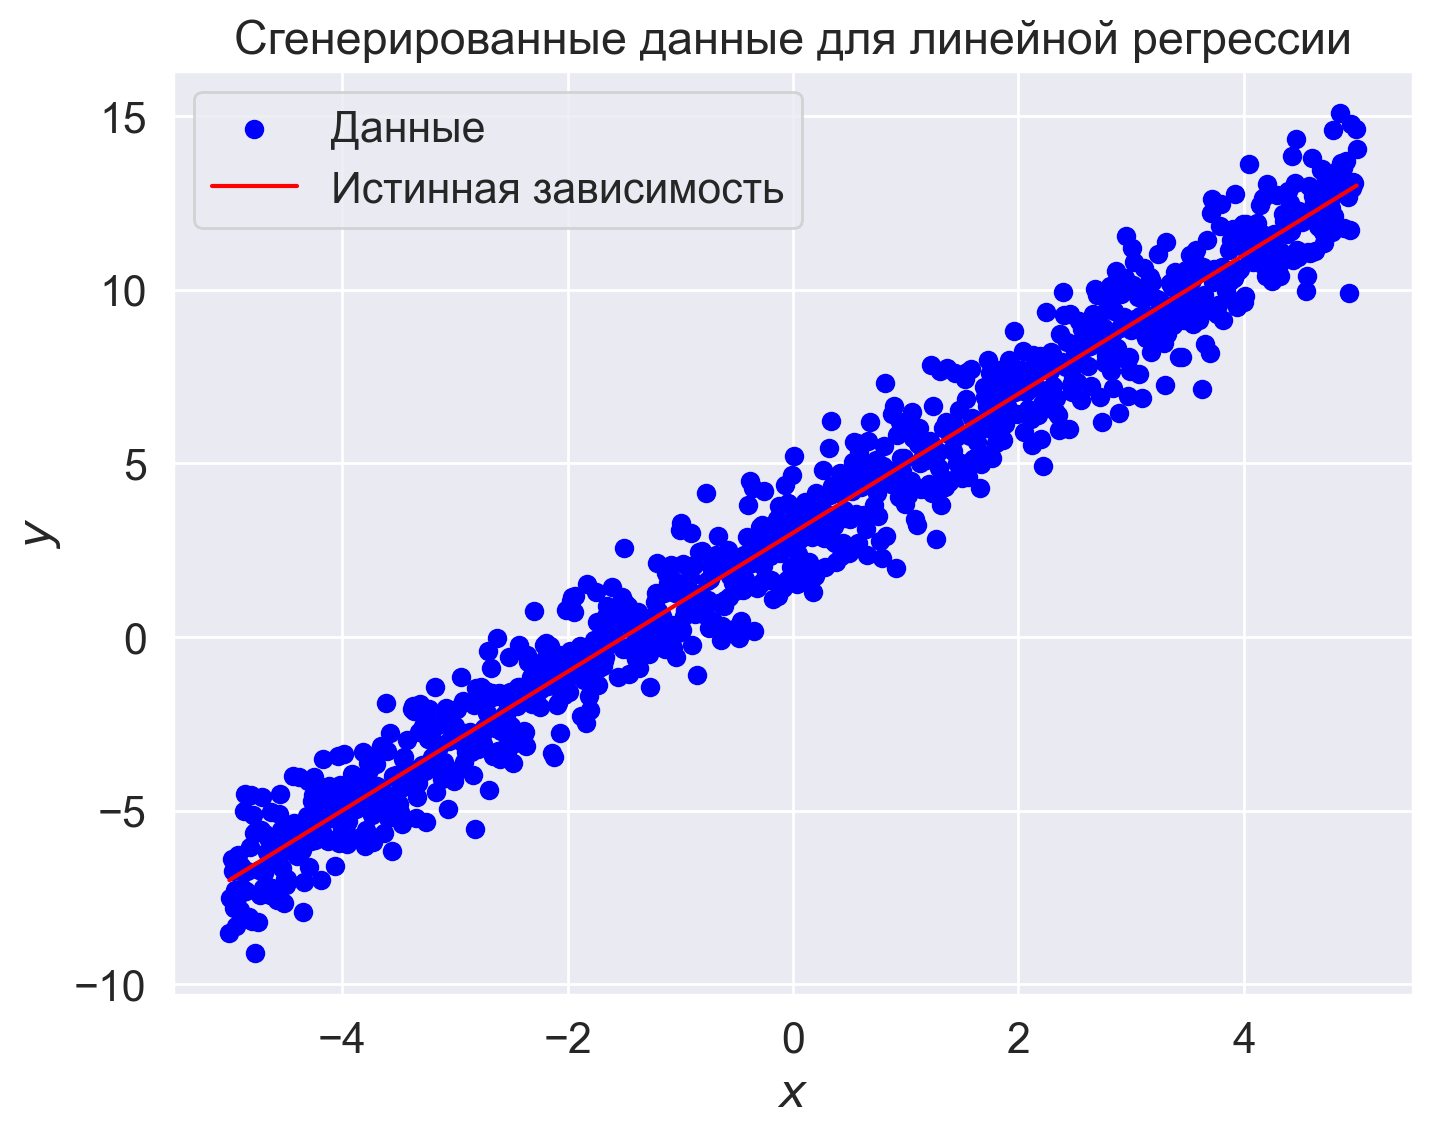

In [17]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', label='Данные')
    plt.plot(x, a * x + b, color='red', label='Истинная зависимость')
    plt.title('Сгенерированные данные для линейной регрессии')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    plt.grid(True)
    plt.show()

Сгенерируйте тестовую выборку тем же способом и посчитайте отклик из формулы Надарая-Ватсона для хотя бы трёх разных ядер (примеры ядер: https://en.wikipedia.org/wiki/Kernel_(statistics)). Сравните ошибки.

$$\widehat{m}_h(x)=\frac{\sum_{i=1}^n K_h(x-x_i) y_i}{\sum_{i=1}^nK_h(x-x_i)}$$

Наши ядра:

In [18]:
def uniform_kern(arr):
    return np.where(np.abs(arr) <= 1, 0.5, 0)

def triangle_kern(arr):
    return np.where(np.abs(arr) <= 1, 1 - np.abs(arr), 0)

def epanech_kern(arr):
    return np.where(np.abs(arr) <= 1, 0.75*(1-arr**2), 0)

Оценка Надарая — Уотсона:

In [19]:
h = 1.0
N_test = 200

отклик и предсказания на его основе:

In [20]:
def m_hat(x_train, y_train, x, kernel, h = h):
    sum_1 = np.sum(kernel((x - x_train) / h) * y_train)
    sum_2 = np.sum(kernel((x - x_train) / h))
    return sum_1 / sum_2

def predict(x_train, y_train, x_test, kernel, h = h):
    return np.array([m_hat(x_train, y_train, x, kernel, h) for x in x_test])

In [21]:
eps_test = sps.norm.rvs(size = N_test)
x_test = np.linspace(-5, 5, N_test)
y_test = x_test * a + b + eps_test

y_pred_uniform = predict(x, y, x_test, uniform_kern)
y_pred_triangle = predict(x, y, x_test, triangle_kern)
y_pred_epanech = predict(x, y, x_test, epanech_kern)

Ошибки с применением ядра _:

In [22]:
MSE_uniform = np.mean((y_pred_uniform - y_test)**2)
MSE_triangle = np.mean((y_pred_triangle - y_test)**2)
MSE_epanech = np.mean((y_pred_epanech - y_test)**2)

print(f"Равномерного = {MSE_uniform}")
print(f"Треугольного = {MSE_triangle}")
print(f"Епанечникова = {MSE_epanech}")

Равномерного = 1.0554325295617244
Треугольного = 1.0158266731385346
Епанечникова = 1.0210672086603598


Визуализируйте Ваши предсказания (постройте кривую предсказаний по сетке x с шагом 0.01)

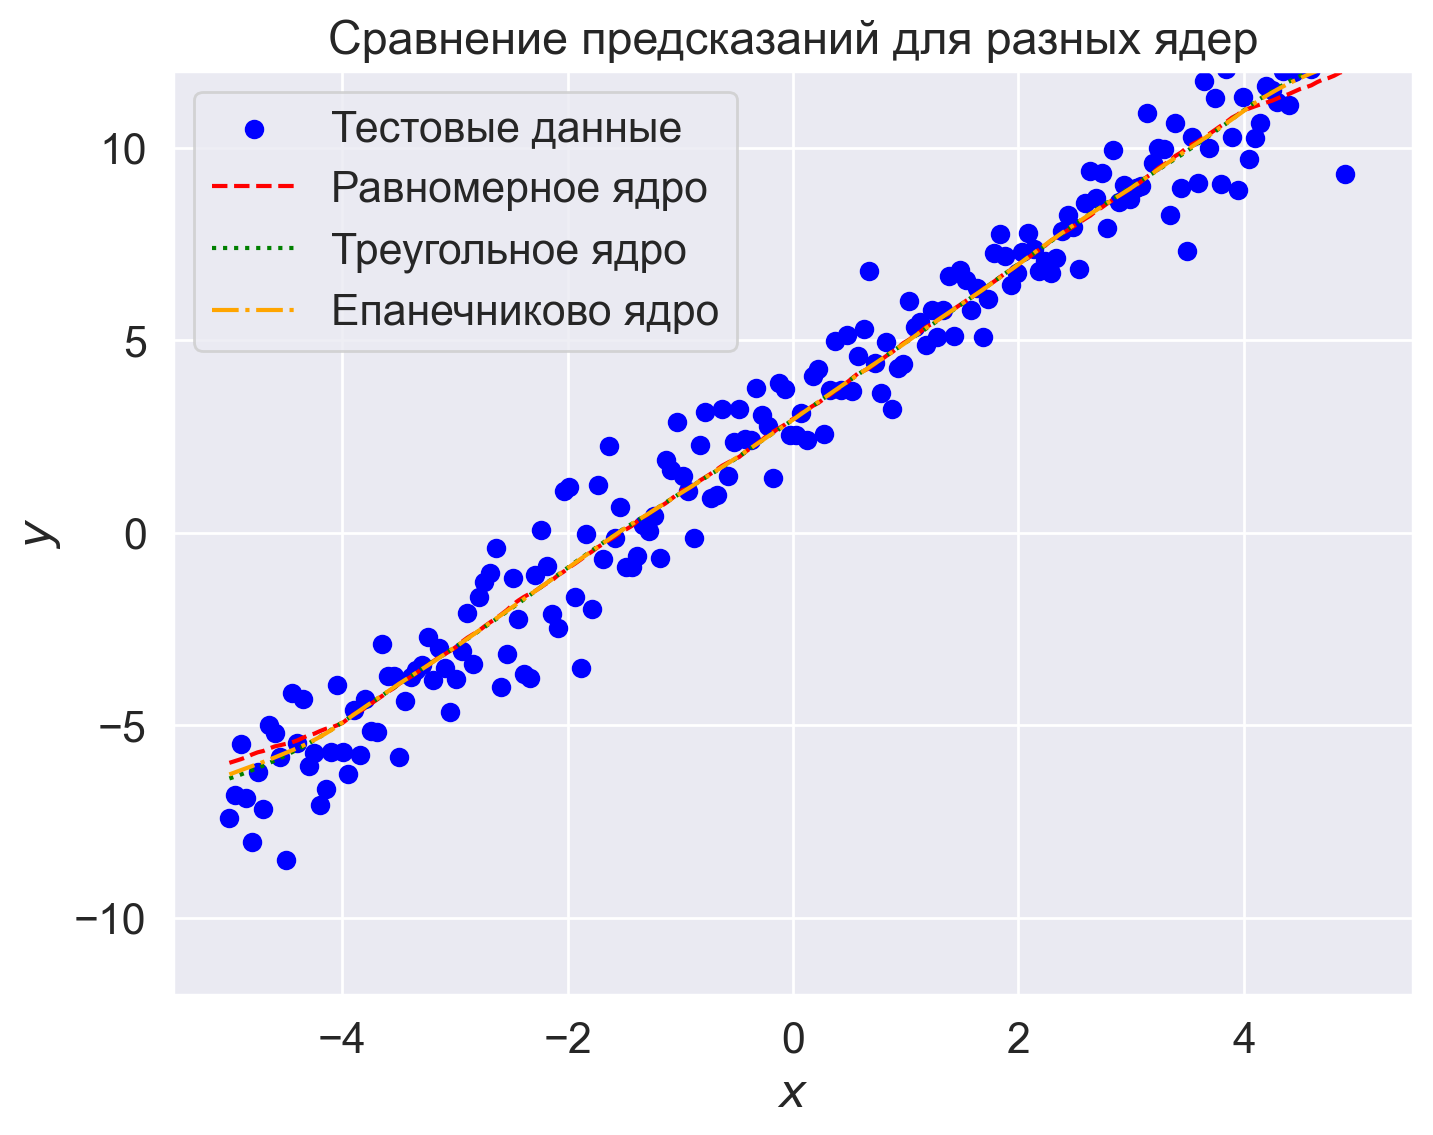

In [23]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_test, y_test, color='blue', label='Тестовые данные')
    plt.plot(x_test, y_pred_uniform, color='red', label='Равномерное ядро', linestyle='dashed')
    plt.plot(x_test, y_pred_triangle, color='green', label='Треугольное ядро', linestyle='dotted')
    plt.plot(x_test, y_pred_epanech, color='orange', label='Епанечниково ядро', linestyle='dashdot')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Сравнение предсказаний для разных ядер')
    plt.legend()
    plt.ylim(-12, 12)
    plt.show()



Все ядра хорошо справляются со своими задачами, на хвостак замечены отклонения но это из за того что мы исследовали выборку на заданном промежутке

Заметим, что мы нигде не оценивали сами параметры, но смогли решить финальную задачу -- предсказывать $y$ по $x$.

А теперь поймём, что для этого не нужна линейность.

Проделайте рассуждения выше для нелинейных зависимостей ($y = sin(kx), y = log(x), y = x^k$. Постройте графики предсказаний и сравните их с истинными функциями.

In [24]:
N = 1000
NN = 200
K = 2
h = 2
sigma = 0.01

In [25]:
eps = sps.norm.rvs(size = N, scale = sigma)
x = np.linspace(20, 30, N)
y_sin = np.sin(K * x) + eps
y_log = np.log(x) + eps
y_polinom = np.pow(x, K) + eps

In [26]:
eps_test = sps.norm.rvs(size = NN, scale = sigma)
x_test = np.linspace(20, 30, NN)
y_sin_test = np.sin(K * x_test) + eps_test
y_log_test = np.log(x_test) + eps_test
y_polinom_test = np.pow(x_test, K) + eps_test

In [27]:
y_sin_unif = predict(x, y_sin, x_test, uniform_kern)
y_sin_trian = predict(x, y_sin, x_test, triangle_kern)
y_sin_epanech = predict(x, y_sin, x_test, epanech_kern)

y_log_unif = predict(x, y_log, x_test, uniform_kern)
y_log_trian = predict(x, y_log, x_test, triangle_kern)
y_log_epanech = predict(x, y_log, x_test, epanech_kern)

y_polinom_unif = predict(x, y_polinom, x_test, uniform_kern)
y_polinom_trian = predict(x, y_polinom, x_test, triangle_kern)
y_polinom_epanech = predict(x, y_polinom, x_test, epanech_kern)

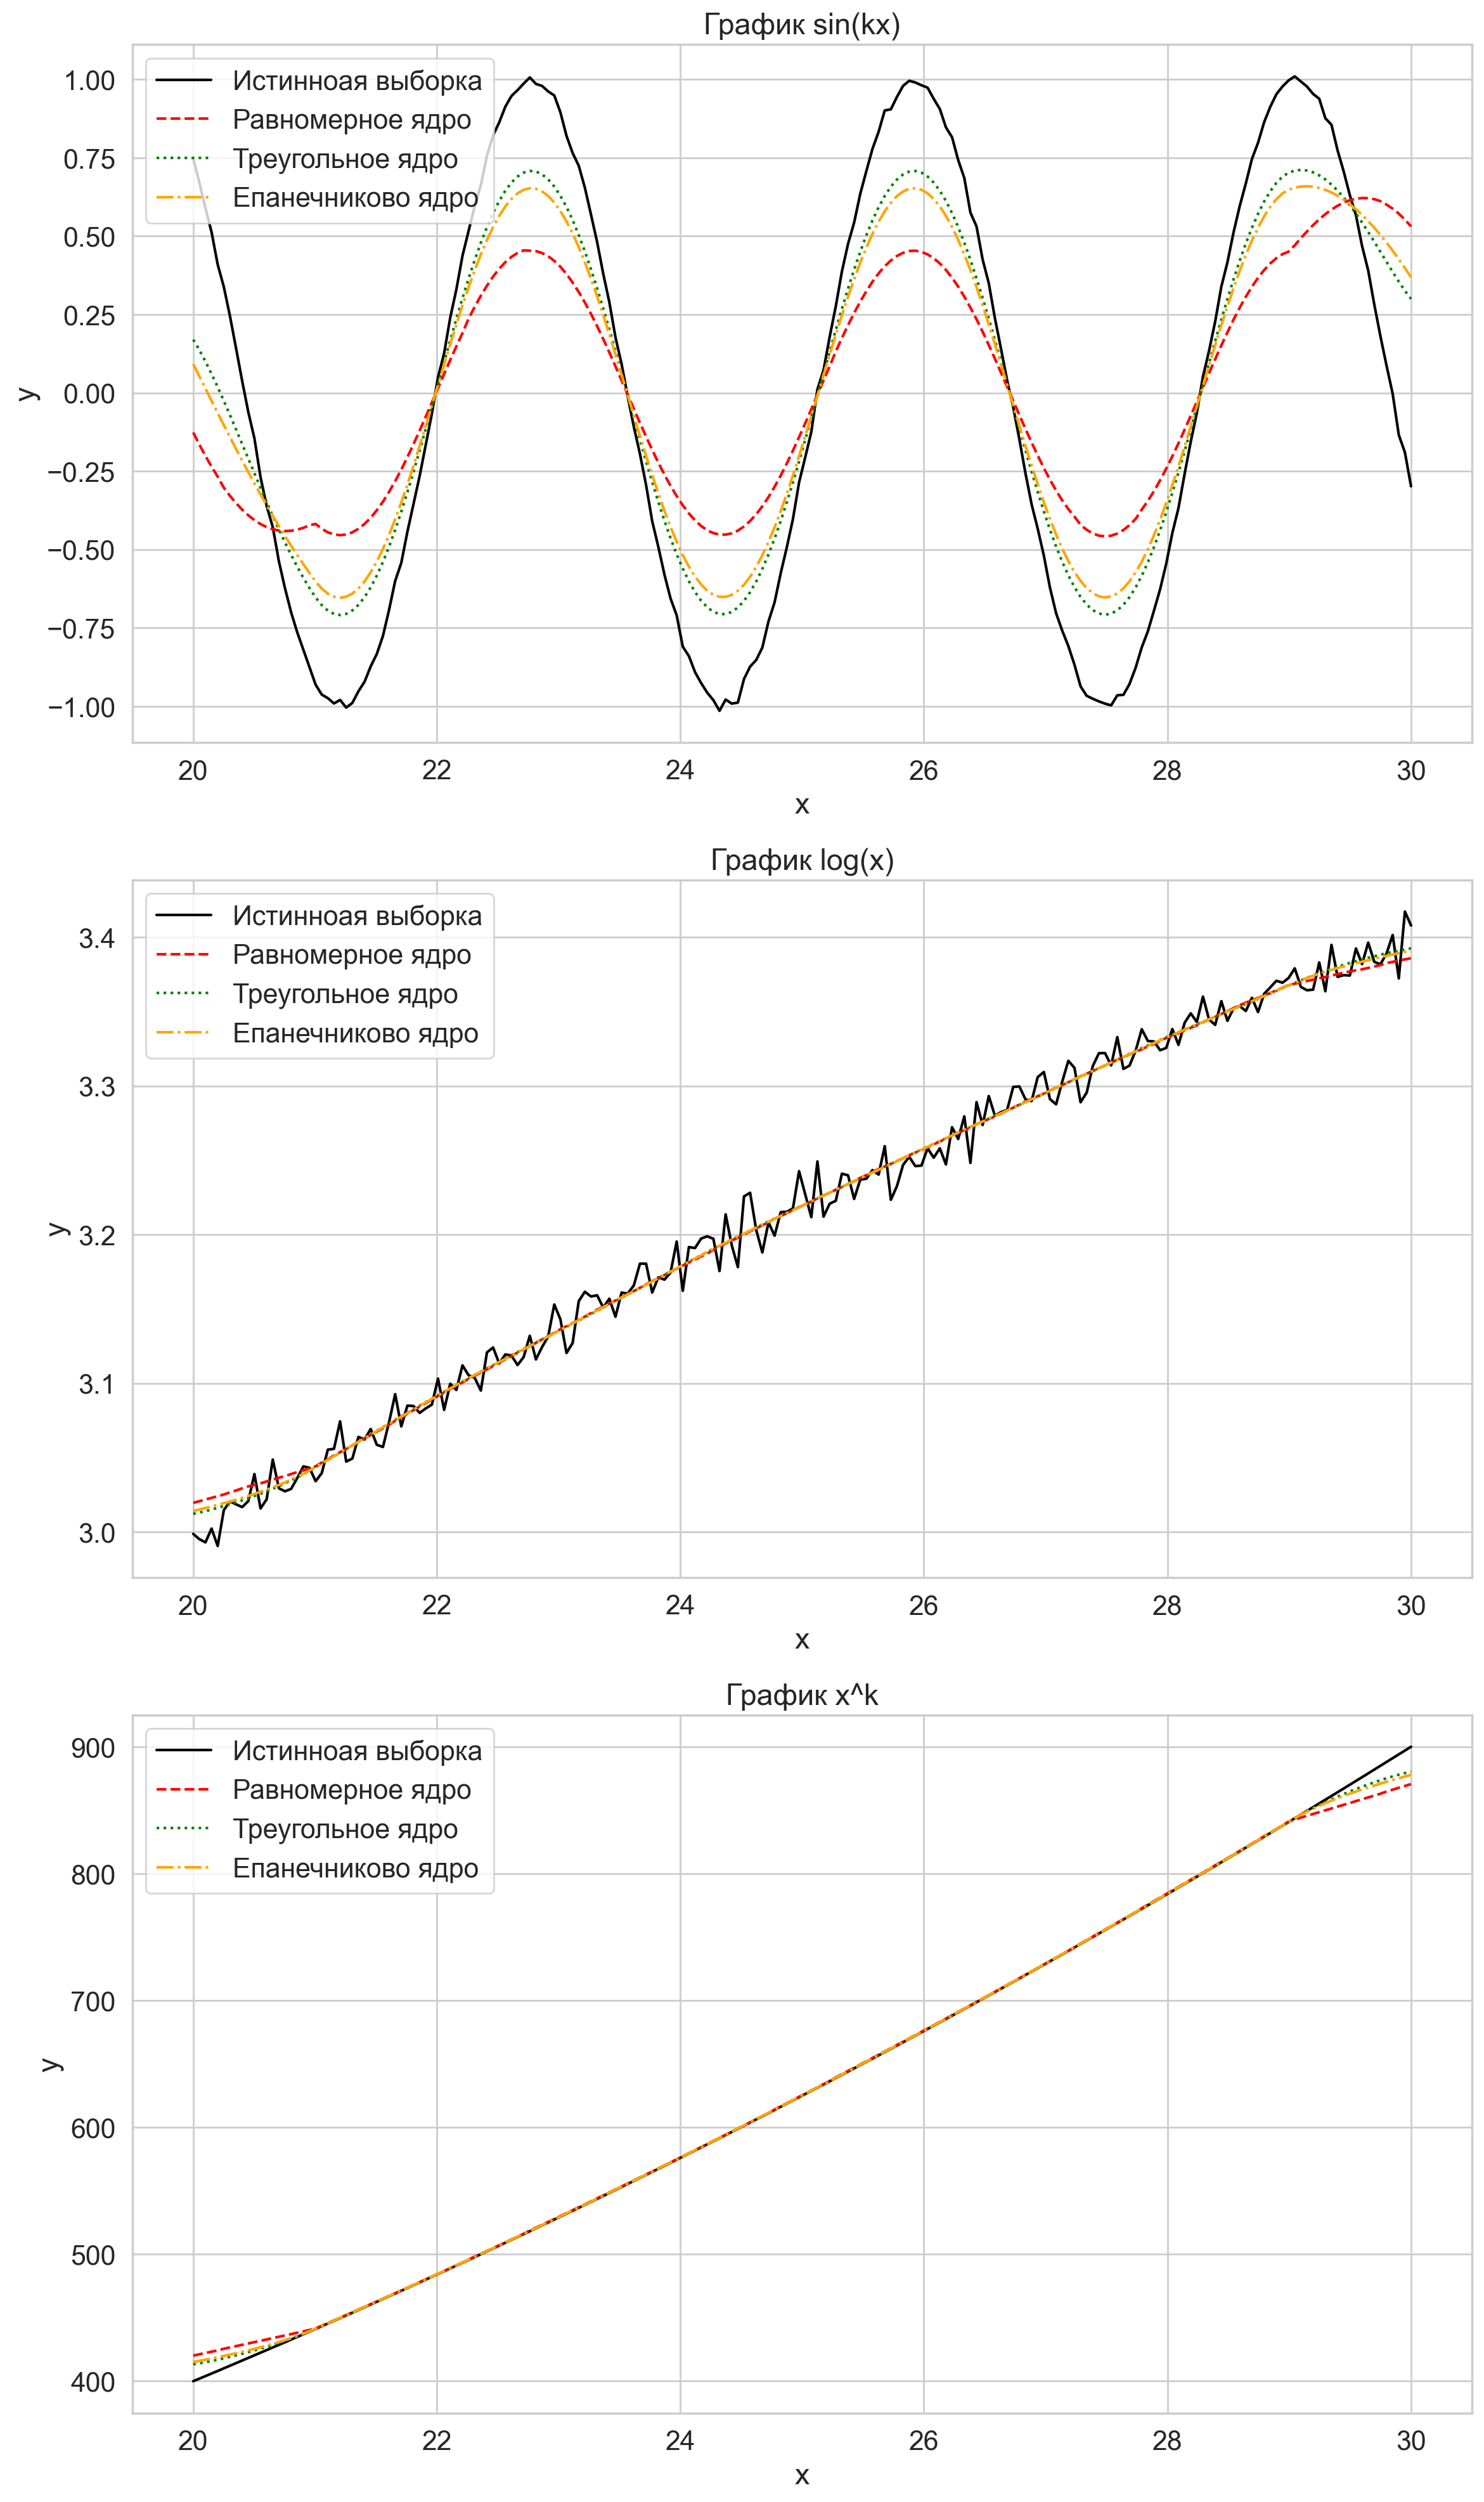

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

sin_list = [y_sin_unif, y_sin_trian, y_sin_epanech]
log_list = [y_log_unif, y_log_trian, y_log_epanech]
polin_list = [y_polinom_unif, y_polinom_trian, y_polinom_epanech]
true_list = [y_sin_test, y_log_test, y_polinom_test]

lists = [sin_list, log_list, polin_list]
ylimits = [[-3, 3], [3, 3.6], [10000, 30000]]
titles = ['График sin(kx)', 'График log(x)', 'График x^k']

for i in range(3):
    axes[i].plot(x_test, true_list[i], color='black', label='Истинноая выборка')
    axes[i].plot(x_test, lists[i][0], color='red', label='Равномерное ядро', linestyle='dashed')
    axes[i].plot(x_test, lists[i][1], color='green', label='Треугольное ядро', linestyle='dotted')
    axes[i].plot(x_test, lists[i][2], color='orange', label='Епанечниково ядро', linestyle='dashdot')
    axes[i].set_title(titles[i])
    # axes[i].set_ylim(ylimits[i][0], ylimits[i][1])
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    axes[i].legend()

plt.tight_layout()
plt.show()

в качестве коментария думаю сойдет вывод ниже:

**Вывод:**
Действительно метод Надарая-Ватсона хорошо предсказывает y из тестовых выборок x.
Равномерное ядро плохо себя показывает при предсказании синусов

Можете попробовать применить метод Надарая-Ватсона для выборки из задачи 3 и посмотреть, что получится (0 баллов)

## Задача 3 (15 баллов)

Теперь давайте попрактикуемся в решении задач на реальных данных. Мы будем анализировать рынок недвижимости 🏘. Данные возьмем из [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на платформе kaggle. В отличие от соревнований нас будут интересовать зависимости в данных, а не более точные предсказания.

![](https://storage.yandexcloud.net/miptstats-public-files/pictures/housesbanner.png)

В частности мы будем смотреть на влияние различных признаков на стоимость дома и проверим несколько гипотез.

In [29]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe

exec: Failed to execute process '/Users/aitore_04/Desktop/all_stuff/материалы мфти/третий_курс_мат/python_prac/myenv/bin/pip': The file specified the interpreter '/Users/aitore_04/Desktop/python_prac/myenv/bin/python3.12', which is not an executable command.
fish: No matches for wildcard 'https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe'. See `help wildcards-globbing`.
gdown https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^


In [30]:
from scipy import stats as sps

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [31]:
df = pd.read_csv("train.csv")

df.fillna("NA", inplace=True)
df.head()

/var/folders/5d/bsm3kt3d4qdc55zn6zggxf800000gq/T/ipykernel_3277/119077902.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("NA", inplace=True)


Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.0     8450   Pave    NA      Reg   
1   2          20       RL        80.0     9600   Pave    NA      Reg   
2   3          60       RL        68.0    11250   Pave    NA      IR1   
3   4          70       RL        60.0     9550   Pave    NA      IR1   
4   5          60       RL        84.0    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [32]:
df

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL        65.0     8450   Pave    NA      Reg   
1        2          20       RL        80.0     9600   Pave    NA      Reg   
2        3          60       RL        68.0    11250   Pave    NA      IR1   
3        4          70       RL        60.0     9550   Pave    NA      IR1   
4        5          60       RL        84.0    14260   Pave    NA      IR1   
...    ...         ...      ...         ...      ...    ...   ...      ...   
1455  1456          60       RL        62.0     7917   Pave    NA      Reg   
1456  1457          20       RL        85.0    13175   Pave    NA      Reg   
1457  1458          70       RL        66.0     9042   Pave    NA      Reg   
1458  1459          20       RL        68.0     9717   Pave    NA      Reg   
1459  1460          20       RL        75.0     9937   Pave    NA      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0     NA     NA          NA       0   
1            Lvl    AllPub  ...        0     NA     NA          NA       0   
2            Lvl    AllPub  ...        0     NA     NA          NA       0   
3            Lvl    AllPub  ...        0     NA     NA          NA       0   
4            Lvl    AllPub  ...        0     NA     NA          NA       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0     NA     NA          NA       0   
1456         Lvl    AllPub  ...        0     NA  MnPrv          NA       0   
1457         Lvl    AllPub  ...        0     NA  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0     NA     NA          NA       0   
1459         Lvl    AllPub  ...        0     NA     NA          NA       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

Можно заметить, что в данных присутствуют категориальные признаки, которые при этом не лишены порядка.

Вспомните курс машинного обучения. Как можно обработать категориальные призаки, чтобы регрессионная модель была осмысленна?

Ответ: переведем все возможные значения категориальных признаков в числа, сохраняя осмысленный порядок который подразумевался изначально

### Визуализируйте данные

Перед тем, как начать использовать линейные модели необходимо убедиться в том, что столбцы признаков не слишком коллинеарны. Для этого можно использовать [корреляцию Пирсона](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#For_a_sample). Используя ``sns.heatmap`` постройте "тепловую карту" попарных корреляций признаков. Для того, чтобы увидеть числовые значения корреляций используйте ``annot=True``. Сделайте размер графика алекватным, например, ``figsize=(11, 10)``.

Какие признаки Вам кажутся самыми полезными? Выберите 9-10 признаков (пока на основании логики) и визуализируйте только их.

Можете использовать предложенные нами:

useful_columns = [
    "OverallQual",
    "GrLivArea",
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

/var/folders/5d/bsm3kt3d4qdc55zn6zggxf800000gq/T/ipykernel_3277/2778990403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].map(mapping)
/var/folders/5d/bsm3kt3d4qdc55zn6zggxf800000gq/T/ipykernel_3277/2778990403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].map(mapping)
/var/folders/5d/bsm3kt3d4qdc55zn6zggxf800000gq/T/ipykernel_3277/2778990403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

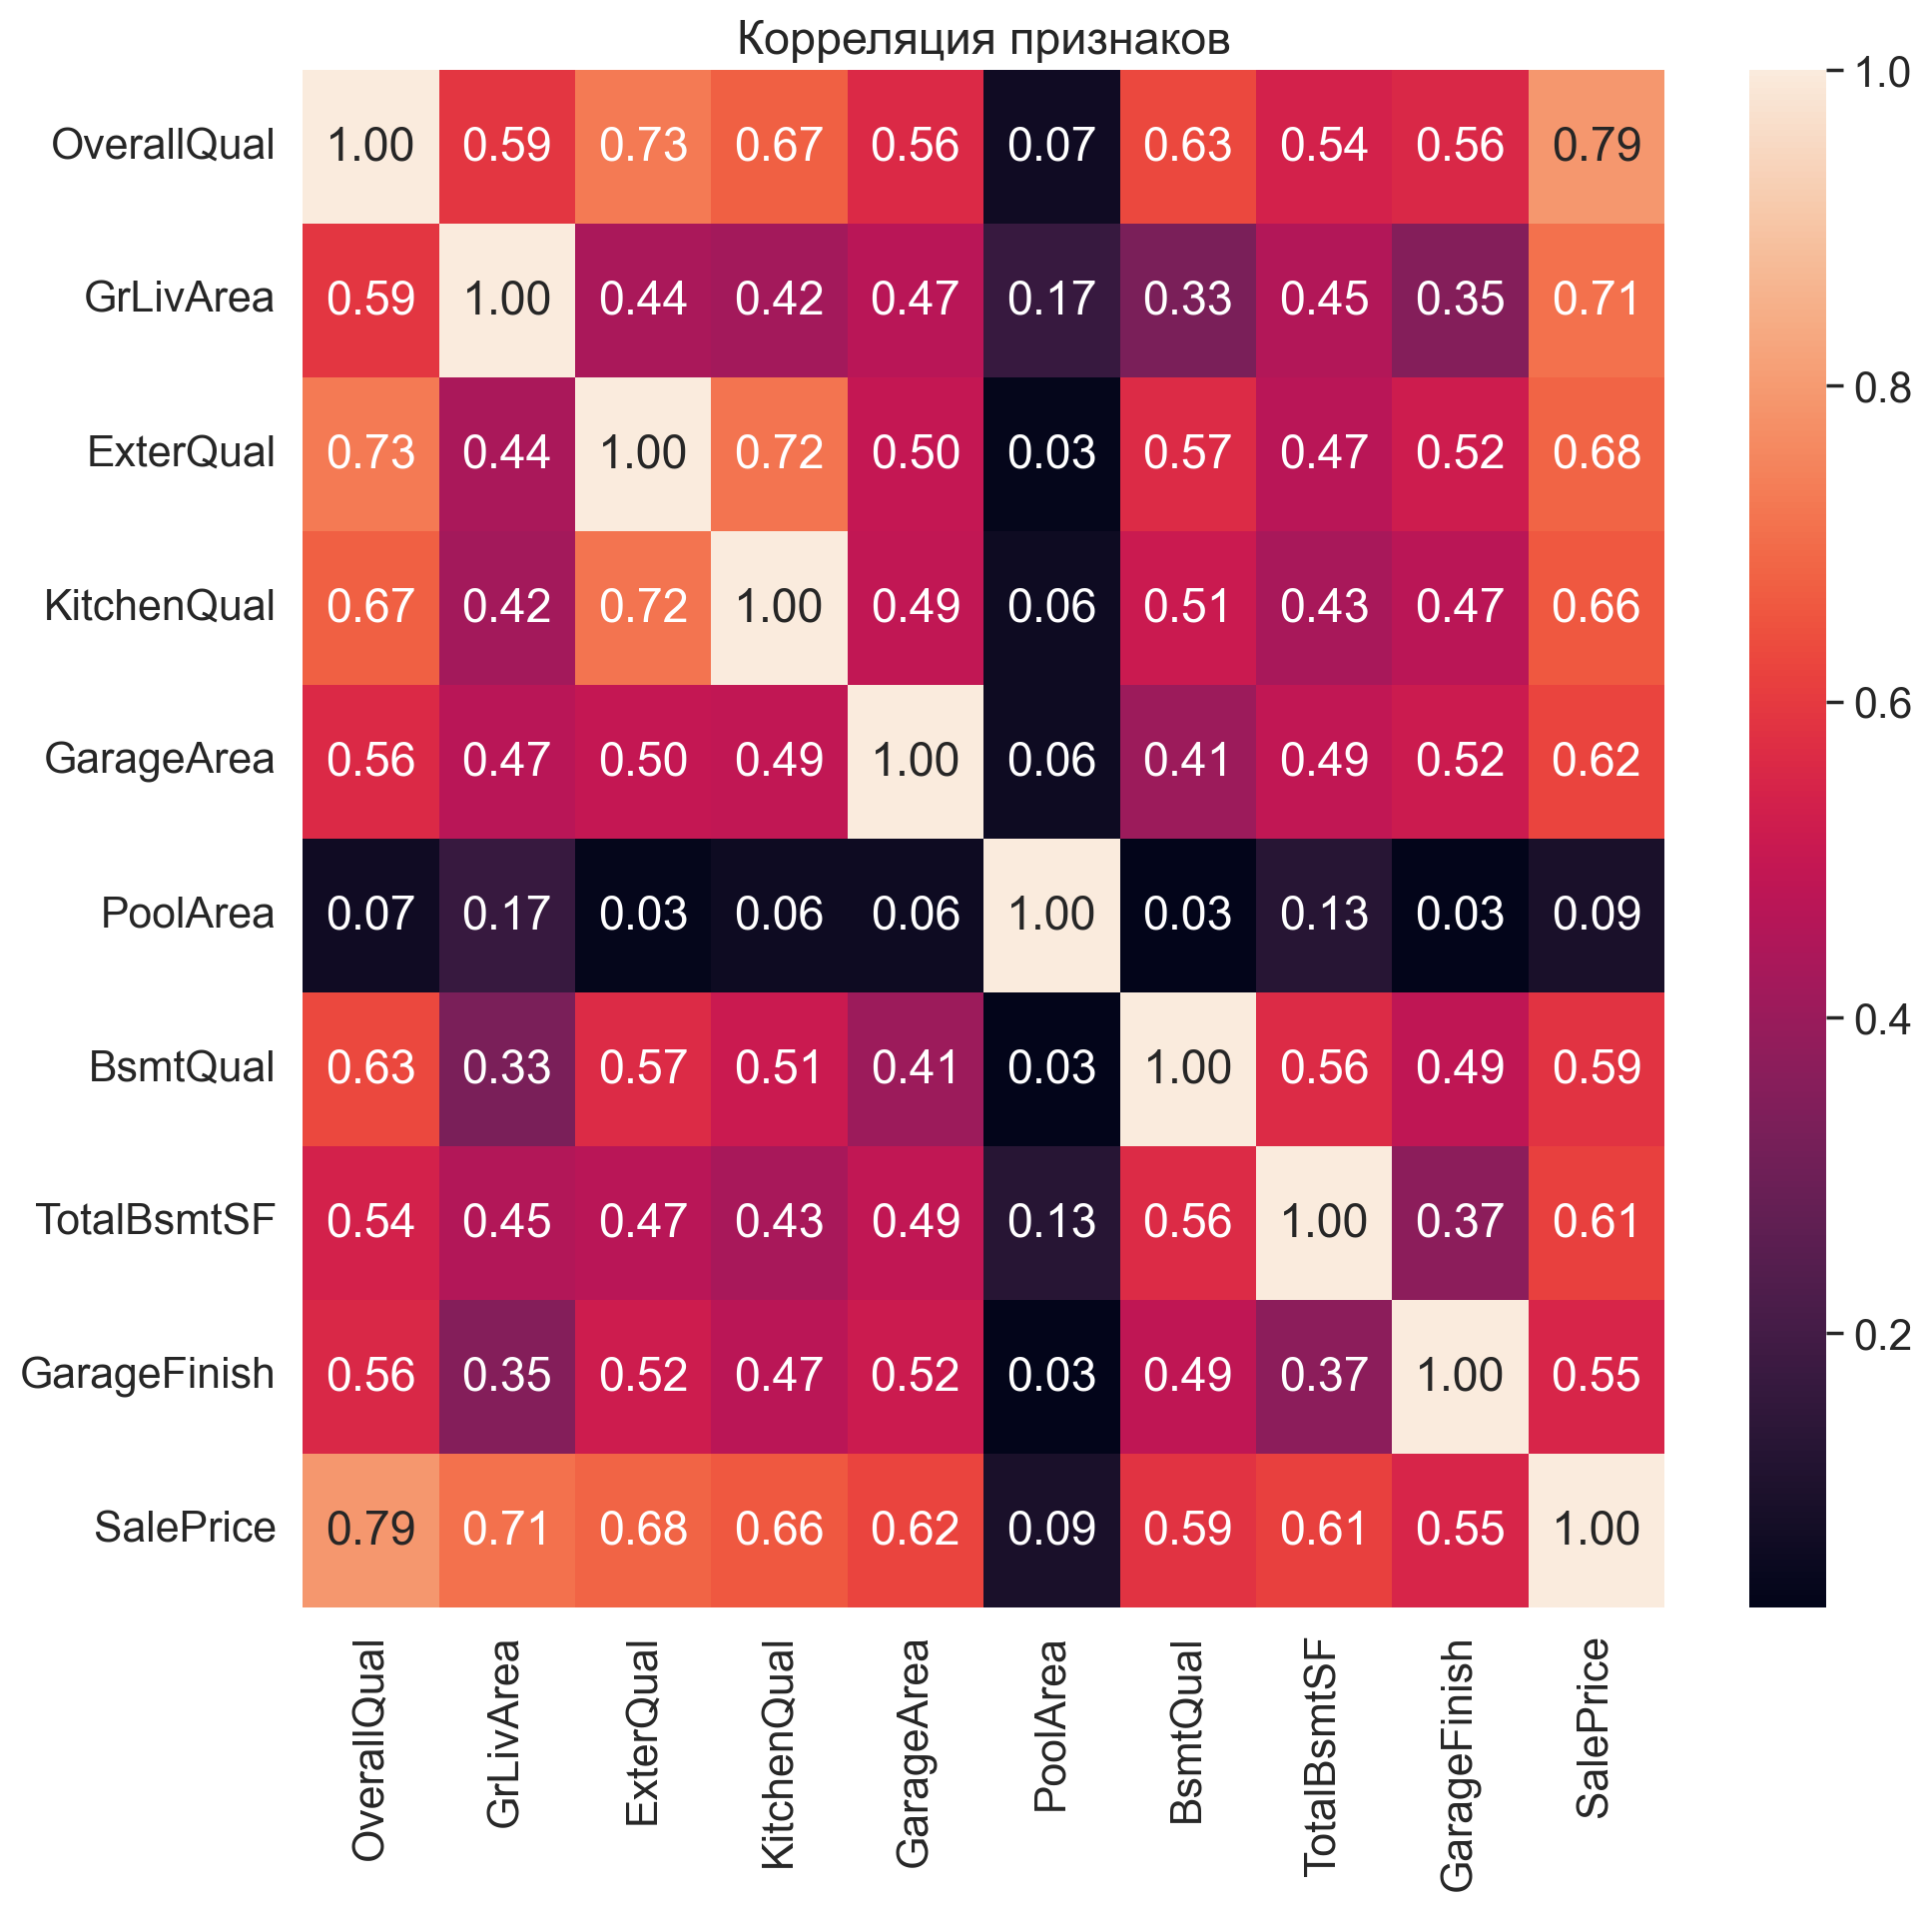

In [33]:
useful_columns = [
    "OverallQual",
    "GrLivArea",
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

filtered_df = df[useful_columns]

ordinal_mappings = {
    'ExterQual': {'NA':0, 'Po': 1, 'Fa': 2, 'TA' : 3, 'Gd': 4, 'Ex': 5},
    'KitchenQual': {'NA':0, 'Po': 1, 'Fa': 2, 'TA' : 3, 'Gd': 4, 'Ex': 5},
    'BsmtQual': {'NA':0, 'Po': 1, 'Fa': 2, 'TA' : 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'NA':0, 'Unf': 1, 'RFn': 2, 'Fin' : 3}
}

for col, mapping in ordinal_mappings.items():
    if col in filtered_df.columns:
        filtered_df[col] = filtered_df[col].map(mapping)

plt.figure(figsize=(11, 10))
sns.heatmap(filtered_df.corr(), annot=True, fmt=".2f",  cbar=True)
plt.title("Корреляция признаков")
plt.show()

Изучите карту и сделайте по ней выводы о зависимости в данных ($|r_{XY}| > 0.9$). А чем плохи зависимые признаки? Для ответа на последний вопрос напишите чему равно аналитическое решение задачи регрессии.

**Ответ:**

По тепловой карте можно заметить что общая стоимость дома сильно корелирует с общим качеством жилья (0.79) а также наблюдается не маленькая корелляция с GrLivArea, ExterQual, KitchenQual, что на самом деле имеет смысл - ведь при выборе жилья домохозяки уделяют большое внимание кухне, внешнему виду дома и жилую площадь

Из за зависимых признаков возникает проблема с выявлением вклада каждого признака, при наличии сильно кореллируемых данных возникает риск переобучения модели.


Удалите, если требуется, один из двух скоррелированных признаков в ячейке ниже.

Давайте подробнее изучим взаимодействие признаков. Построим матрицу. На диагонале $a_{ii} = d_i$ этой матрицы построим гистограммы для $i$-го признака. На остальных позициях $a_{ij}$ будут располагаться scatterplot в осях признака $i$ по $x$ и признака $j$ по $y$. Для этого можно использовать метод из pandas ``pd.plotting.scatter_matrix``.

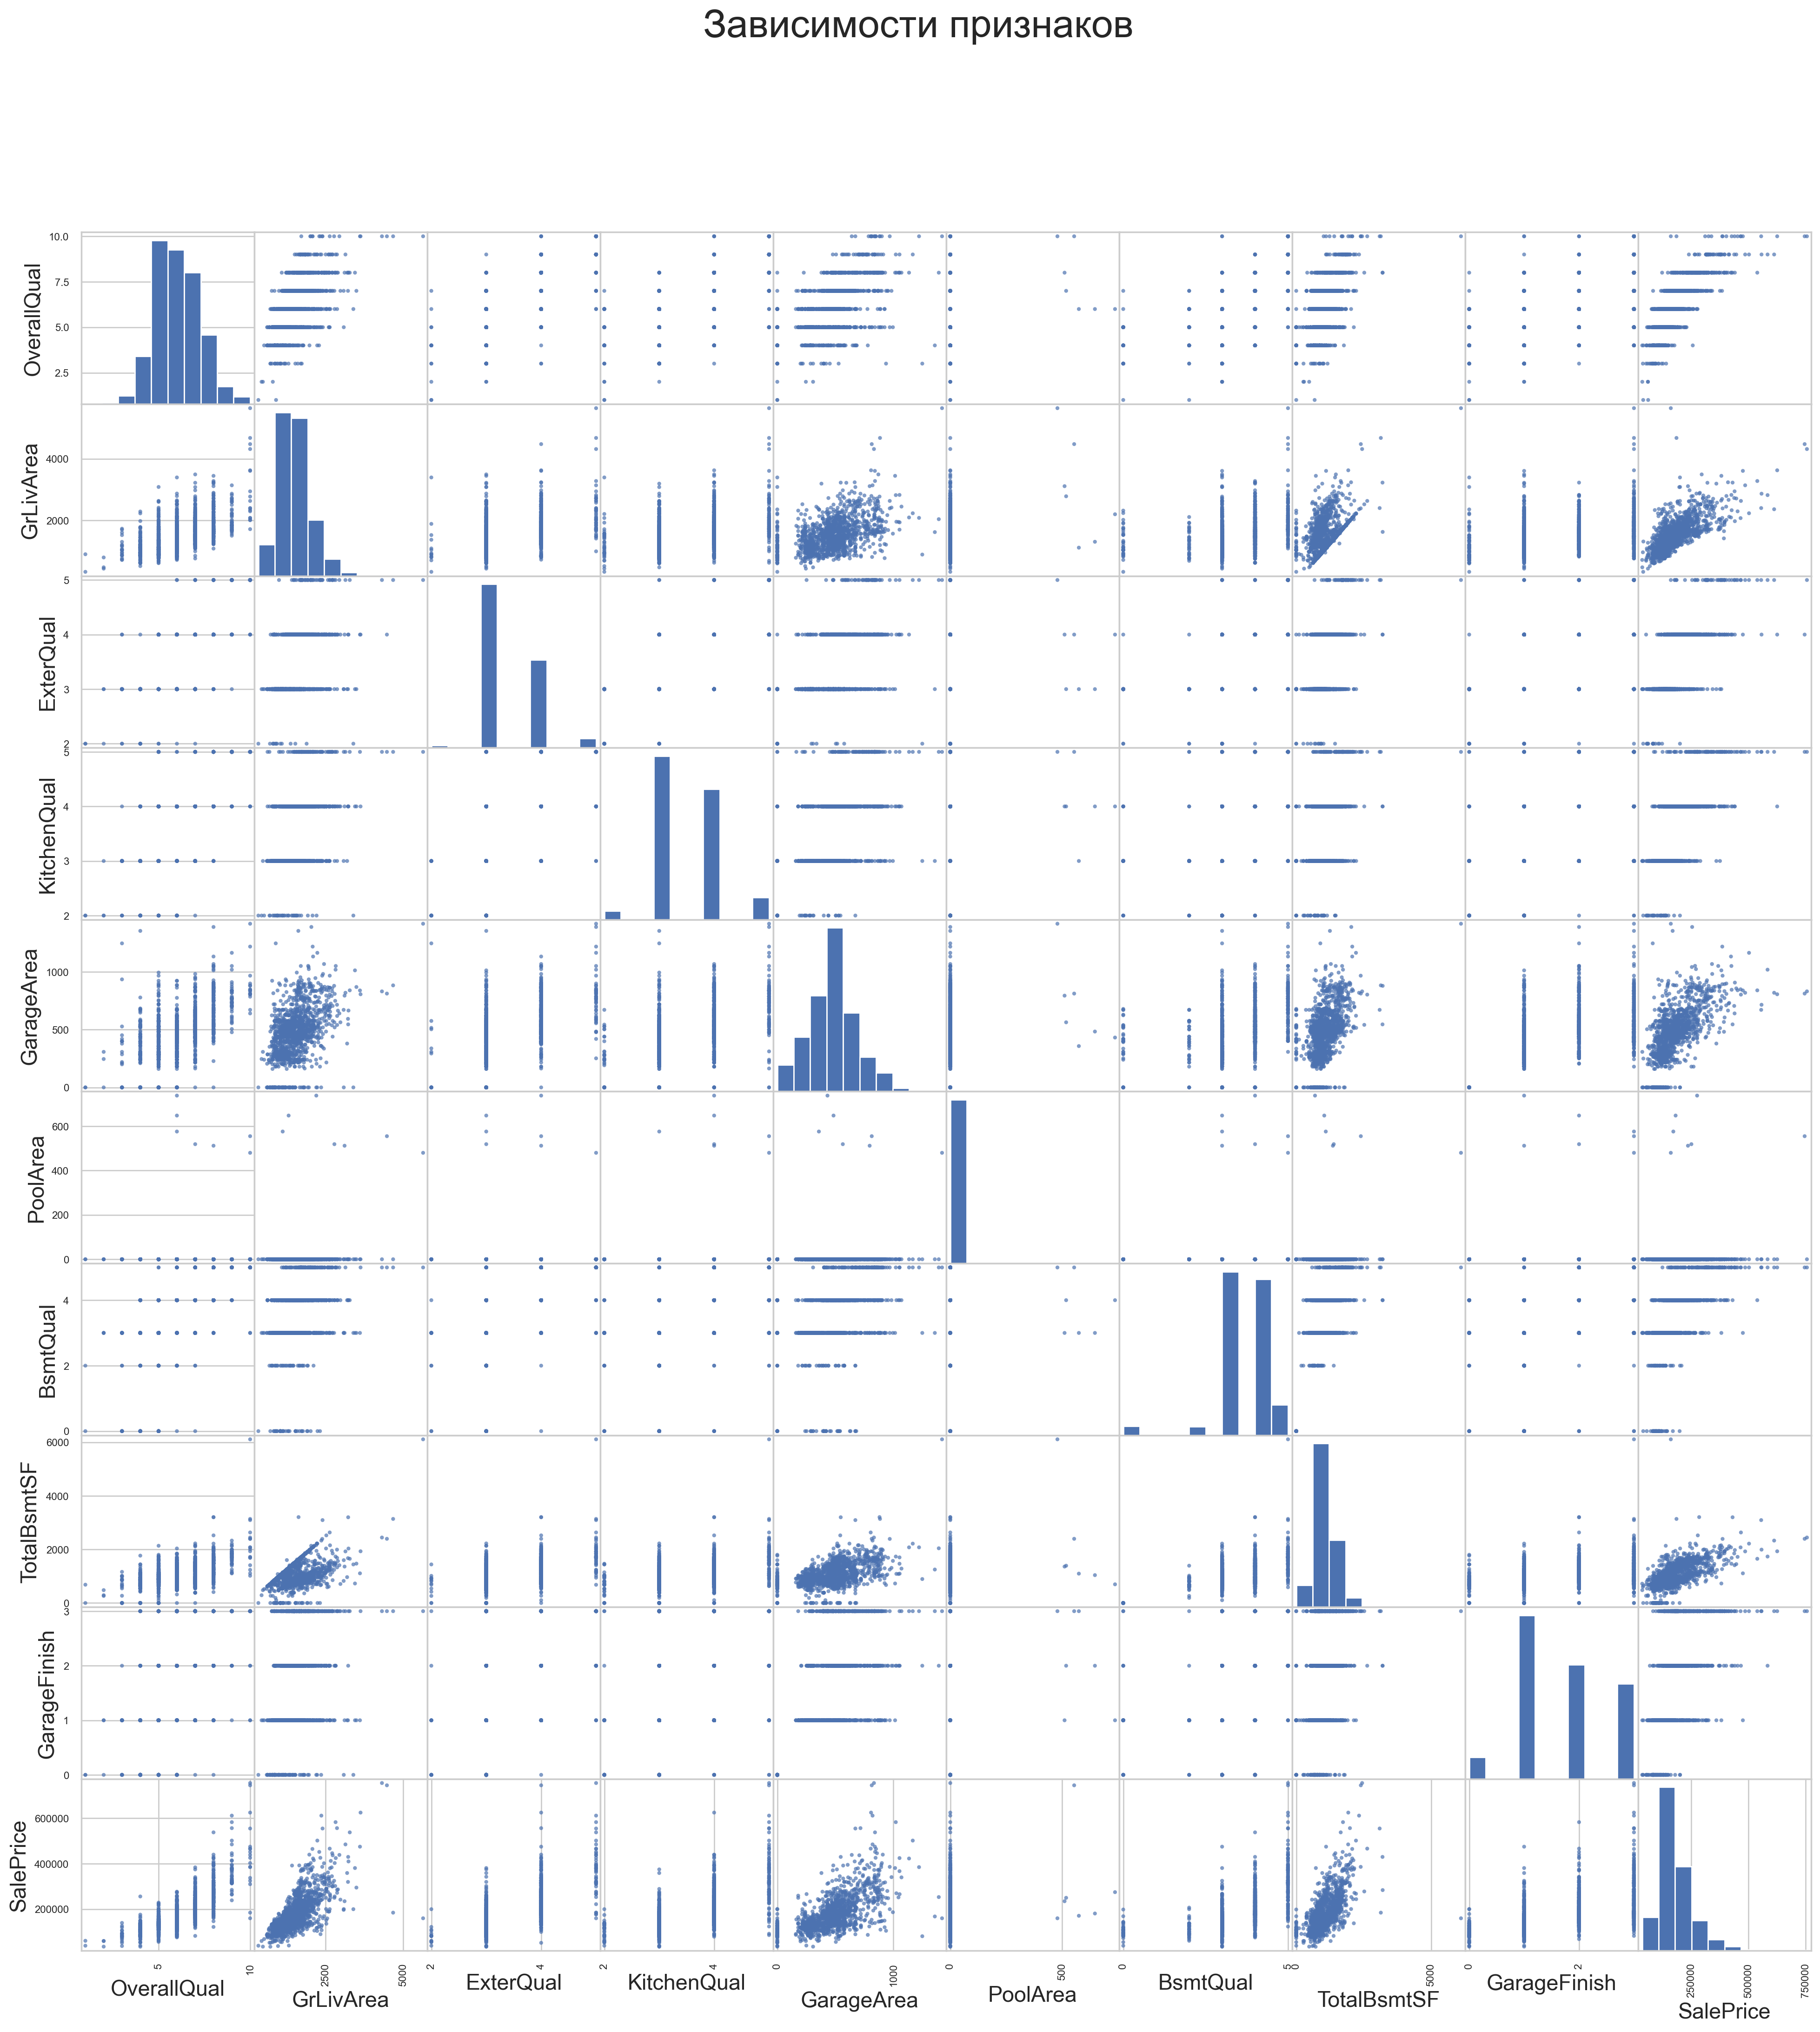

In [34]:
pd.plotting.scatter_matrix(filtered_df, figsize=(24, 24), alpha=0.7, diagonal='hist')
plt.suptitle("Зависимости признаков", fontsize=30)
plt.show()

Сделайте вывод о данных. Опишите, нужна ли регуляризация и почему?

Я считаю что тут нужна регуляризация, ведь в данных присутствуют довольно сильно коррелируемые признаки что может привести модель к переобучению

### Как пользоваться линейными моделями

Как можно догадаться, на практике никто не пишет заново свои линейные модели. Для машинного обучения часто используют библиотеку scikit learn, для аналитики statsmodels. С первой вы познакомитесь (или уже познакомились) на курсе по ML, мы же сконцентрируемся на второй.

Итак, библиотека statsmodels состоит из множества реализованных критериев и, как ни странно, статистических моделей. Основным плюсом является то, что нам не нужно реализовывать критериии вручную, все сделано за нас (это не значит что думать не надо!).

Начнем с линейной модели: для того, чтобы ее создать понадобится лишь одна строка.  Как видно в ячейке ниже мы задаем формулу того, какую модель мы хотим получить. В данном случае мы хотим предсказать ``SalePrice`` по взвешенной сумме из остальных признаков.

In [35]:
formula = "SalePrice ~ " + " + ".join(useful_columns[:-1])

print(formula)

SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + PoolArea + BsmtQual + TotalBsmtSF + GarageFinish


Теперь эту формулу мы просто передаем в модель, а так же подаем ей данные. В формуле написаны имена колонок из ``filtered_df``.

In [36]:
simple_model = smf.ols(formula, data=filtered_df)

fitted_simple_model = simple_model.fit()

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     581.5
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:30:07   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1450   BIC:                         3.493e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.483e+05   6394.344    -23.185   

### Гетероскедастичность ошибки

**гомоскедастичностью** называют свойство одинаковости дисперсии и независимость остатков модели.

Оценка, полученная с помощью гауссовской линейной модели будет справедлива лишь при выполнении условия гомоскедастичности остатков. Для проверки на гомоскедастичность часто используют критерий Бройша — Пагана. Мы не будем вдаваться в детали и доказательство того, что критерий валидный и работает правильно. Итак, критерий Бройша — Пагана проверяет нулевую гипотезу о гомоскедастичности распределения данных против альтернативы, то есть гетероскедастичности. Если нулевая гипотеза отвергается то можно сказать, что данные распределены ГЕТЕРОскедастично. Мы этого не хотим.

Критерий реализован с помощью функции ``sms.diagnostic.het_breuschpagan``. Документацию можно найти [здесь](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

Остатки модели можно из поля ``fitted_model.resid``, а параметры из ``fitted_model.model.exog``.

Нас интересует p-value для множителя Лагранжа.

В ячейке ниже получите уровень достигаемой значимости для критерия Бройша — Пагана.

In [37]:
p_val_het = sms.diagnostic.het_breuschpagan(resid=fitted_simple_model.resid,
                                            exog_het=fitted_simple_model.model.exog)[1]

print(f"p-value simple: {p_val_het}")

p-value simple: 5.431361130975639e-95


Пока не вдаваясь в проверку гипотез просто будем считать, что критерий точно проверяет условие гомоскедастичности.

Отвергается ли гипотеза о гомоскедастичности остатков (определение из будущего: гипотеза отвергается, если pvalue < 0.05 и это значит, что её утверждение полагается неверным)? Что это означает?

**Ответ:**

Да, отвергается, так как p-value < 0.05 что значит что мы имеем дело с гетероскедостичностью.
Это означает, что дисперсия остатков не является постоянной для всех значений предсказании,  ошибки модели систематически изменяются в зависимости от предсказанных значений

В случаях, когда распределения остатков не является гомоскедастичном оценка по-прежнему остается несмещенной, однако стоит сделать некоторую поправку, на более высокую дисперсию. Поэтому значения F-критериев и t-критериев для коэффициентов стоит пересмотреть. Для таких случаев существует достаточно много различных поправок, одно из семейств таких поправок называется поправки Уайта на гетероскедастичность. Ниже мы попробуем использовать одну из поправок.

Для этого, в ячейке ниже, обучите линейную модель, но на этот раз передайте в метод ``.fit`` аргумент ``cov_type="HC1"``.

Получите summary для такой модели.

In [38]:
enh_simple_model = smf.ols(formula, data=filtered_df)

enh_fitted_simple_model = enh_simple_model.fit(cov_type="HC1")

print(enh_fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     266.7
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          5.44e-300
Time:                        21:30:07   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1450   BIC:                         3.493e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.483e+05   9507.281    -15.594   

Проанализируйте результаты. Как изменились показатели из таблицы?

**Ответ:**

уменьшилась F-statistic -> Это отражает более точную интерпретацию данных при наличии гетероскедастичности

У признака PoolArea возросло значение pvalue что значит что этот признак не так сильно влияет на предсказания целевого значения

Теперь мы действительно можем оценивать то, насколько важен тот или иной признак.



Проведите отбор признаков методами с семинара. Начните с того, что выберите около 15 признаков, которые Вам кажутся разумными и отберите лучшие 3, 5 и 10 из них.

In [39]:
my_columns = [
    "MSSubClass",
    "OverallQual",
    "LotArea",
    "Street",
    "GrLivArea",
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

my_df = df[my_columns].copy()

pave_map = {'NA':0, 'Grvl':1, 'Pave':2}
qual_map = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
garage_map = {'NA':0, 'Unf':1, 'RFn':2, 'Fin' :3}

my_df['Street'] = my_df['Street'].map(pave_map)
my_df['ExterQual'] = my_df['ExterQual'].map(qual_map)
my_df['KitchenQual'] = my_df['KitchenQual'].map(qual_map)
my_df['BsmtQual'] = my_df['BsmtQual'].map(qual_map)
my_df['GarageFinish'] = my_df['GarageFinish'].map(garage_map)

my_formula = "SalePrice ~ " + " + ".join(my_columns[:-1])

In [49]:
my_model = smf.ols(my_formula, data=my_df)

fitted_my_model = my_model.fit(cov_type="HC1")

print(fitted_my_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     210.5
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          7.76e-307
Time:                        21:35:02   Log-Likelihood:                -17386.
No. Observations:                1460   AIC:                         3.480e+04
Df Residuals:                    1447   BIC:                         3.487e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -1.73e+05    2.1e+04     -8.247   

In [50]:
pvalues = fitted_my_model.pvalues
pvalues = pvalues.sort_values()

print("Важнейшие 10 признаков")
print(pvalues.head(10))

Важнейшие 10 признаков
GrLivArea       1.232070e-21
OverallQual     6.994123e-21
Intercept       1.630153e-16
KitchenQual     2.093997e-14
GarageArea      3.535540e-09
LotArea         5.798432e-08
ExterQual       6.182541e-07
MSSubClass      1.190578e-05
BsmtQual        6.019080e-04
GarageFinish    9.543180e-04
dtype: float64


In [51]:
pvalues

GrLivArea       1.232070e-21
OverallQual     6.994123e-21
Intercept       1.630153e-16
KitchenQual     2.093997e-14
GarageArea      3.535540e-09
LotArea         5.798432e-08
ExterQual       6.182541e-07
MSSubClass      1.190578e-05
BsmtQual        6.019080e-04
GarageFinish    9.543180e-04
Street          2.074622e-01
TotalBsmtSF     2.695062e-01
PoolArea        7.913288e-01
dtype: float64

как можно заметить по выводу выше, показаны самые важные признаки в нашем наборе признаков

Какие признаки оказались не значимы и почему?

**Ответ:** незначимыми оказались GarageFinish, PoolArea, Street. Видимо они влияют на выбор не так сильно как остальные.
Если так подумать то и вправда наличие бассейна и улицы не сильно важны при выборе дома

Теперь снова обучим новую модель только на значимых признаках и получим summary. Не забудьте про поправку Уайта!

In [43]:
best_columns = ['GrLivArea', 'OverallQual', 'KitchenQual', 'SalePrice']
best_df = my_df[best_columns]
best_formula = "SalePrice ~ " + " + ".join(best_columns[:-1])

In [44]:
best_model = smf.ols(best_formula, data=best_df)

fitted_best_model = best_model.fit(cov_type="HC1")

print(fitted_best_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     517.7
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          6.81e-229
Time:                        21:30:07   Log-Likelihood:                -17560.
No. Observations:                1460   AIC:                         3.513e+04
Df Residuals:                    1456   BIC:                         3.515e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.442e+05   9312.582    -15.482      

Как изменился коэффициент $R^2$? Всегда ли бОльший $R^2$ говорит о правильной модели? Расскажите о своих рассуждениях!

**Ответ:** коэффицент $R^2$ в новой не сильно поменялся, видимо выбранные нами лучшие признаки оказались и вправду лучшими.
Но большое значение не всегда свидетельствует о правильности модели, на размер коэффицента может влиять число признаков и с каждым добавлением признака модель будет находить дополнительные способы объяснить данные



### Преобразование целевого признака

Обратим свое внимание на целевую переменную. Ниже постройте гистограммы для признака ``SalePrice``. А так же для логарифма от ``SalePrice``. Сделайте это на разных картинках. Можно использовать subplot.

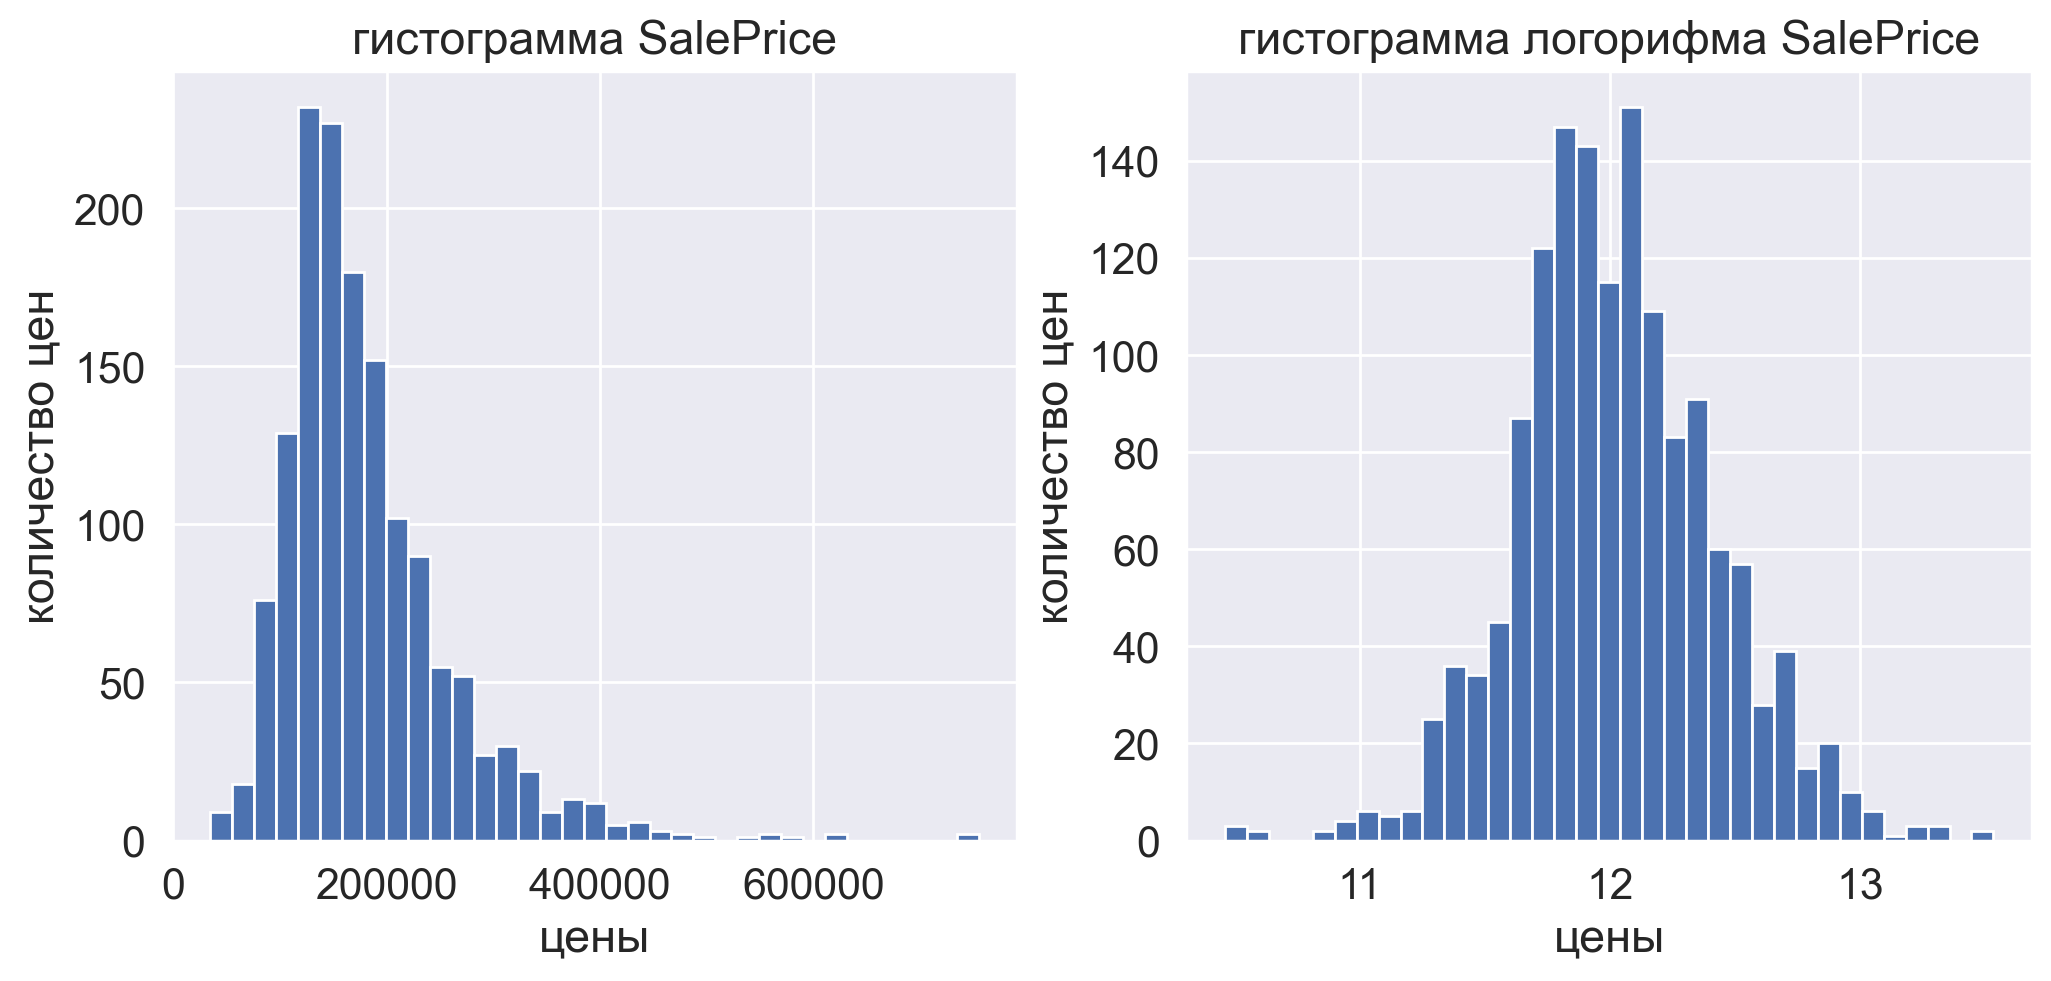

In [45]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize = [12, 5])
    axes[0].hist(df["SalePrice"], bins = 35)
    axes[0].set_title("гистограмма SalePrice")
    axes[0].set_ylabel("количество цен")
    axes[0].set_xlabel("цены")

    axes[1].hist(np.log(df["SalePrice"]), bins = 35)
    axes[1].set_title("гистограмма логорифма SalePrice")
    axes[1].set_ylabel("количество цен")
    axes[1].set_xlabel("цены")
    plt.show()

Какой из графиков выглядит более "Гауссовским"?

**Ответ:** по видимому график логорифмов

Теперь давайте снова посмотрим на распределение остатков от линейной модели. Начертим qqplot для нормального распределения и гистограмму остатков.

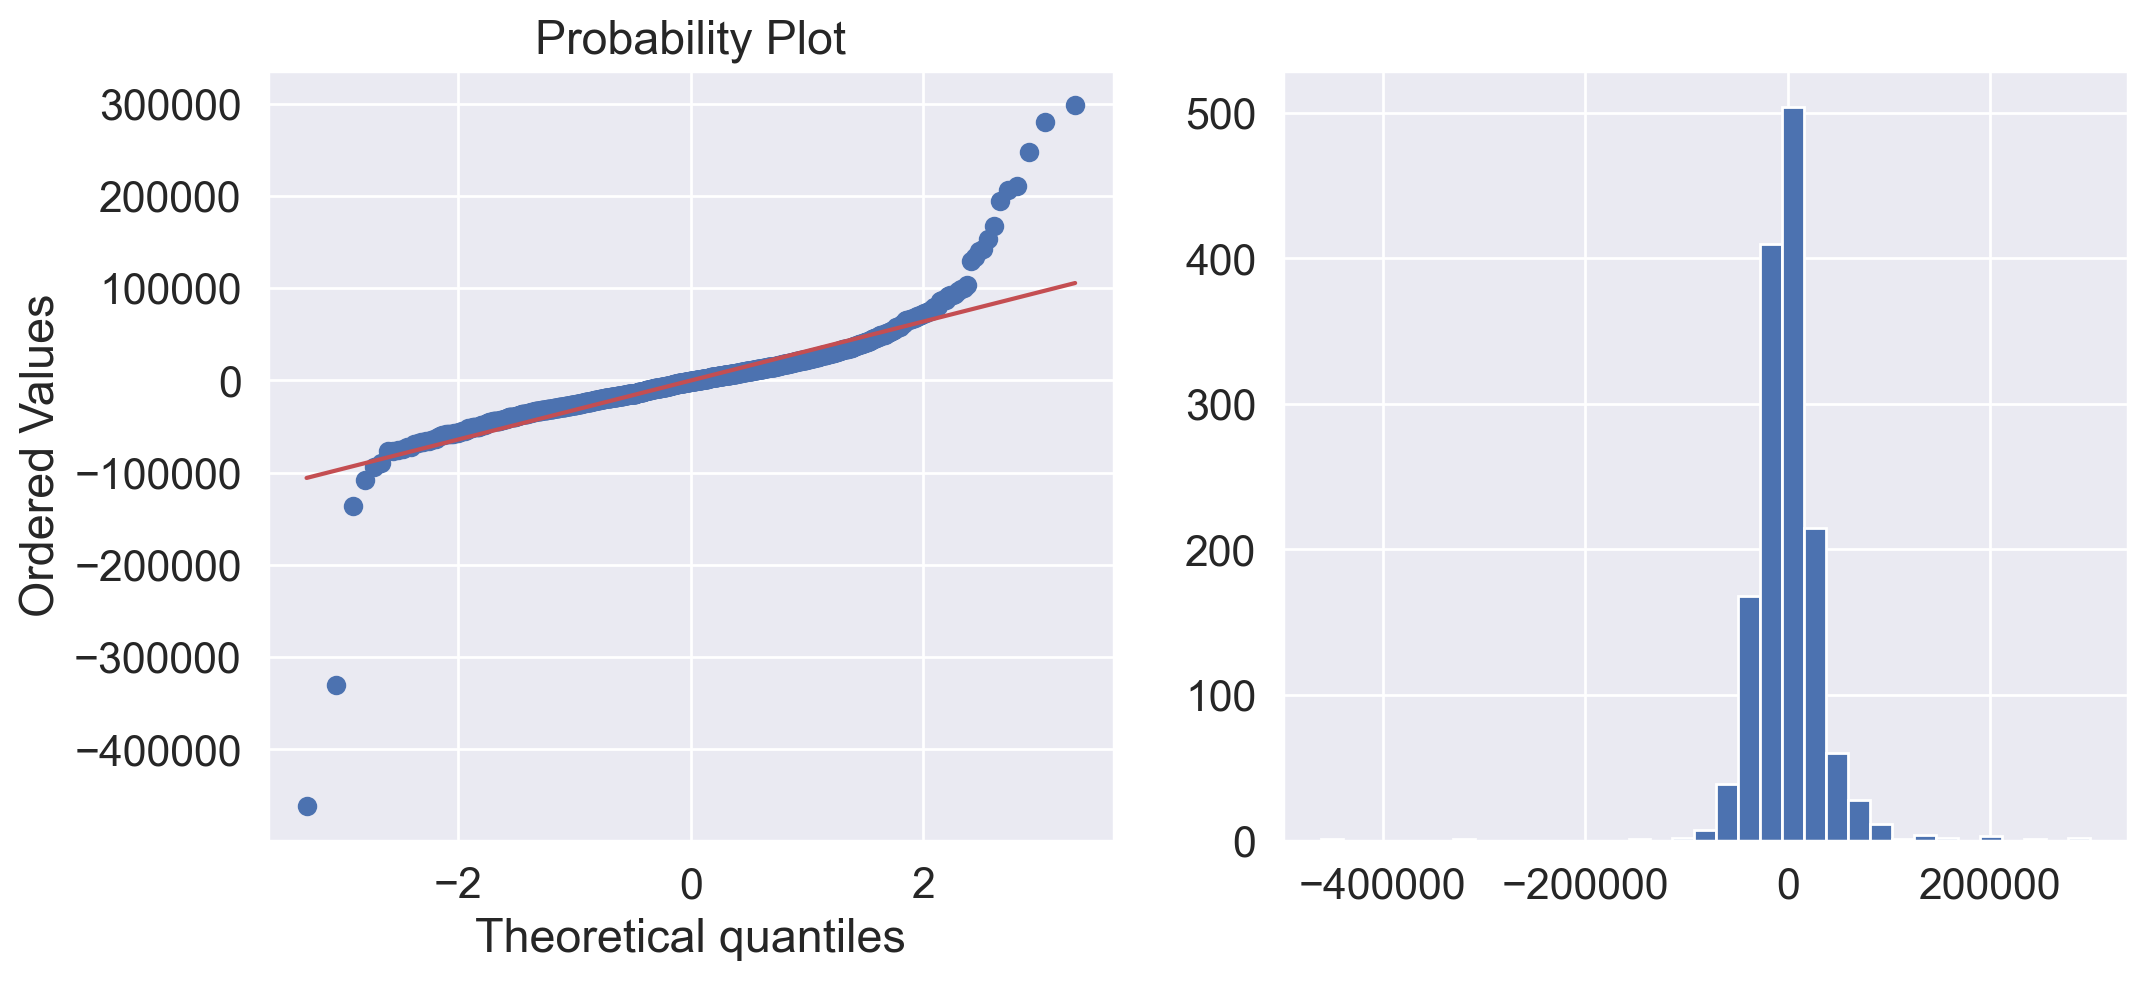

In [57]:
my_resid = np.array(fitted_my_model.resid)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize = [12, 5])
    sps.probplot(my_resid, dist=sps.norm(loc = 0, scale = 1), plot = axes[0])
    plt.hist(my_resid, bins = 35)


Как вы считаете, можно ли сказать, что распределение остатков это нормальное распределение?

**Ответ:** не совсем, видно что есть линейность в QQ-plot на отрезке [-2,2] но дальше в правом конце хвост становятся тяжелее.

Давайте обучим модель предсказывать не SalePrice, а ее логарифм. Для этого снова обновим формулу для модели. Прелесть формул в том, что в них можно использовать операции из numpy. Например можно искать зависимость не от ``PoolArea``, а от ее квадрата, то есть ``np.power(PoolArea, 2)``. Достаточно просто добавить в формулу ..." + np.power(PoolArea, 2)" и все заработает!

В ячейке ниже обучите модель предсказывать логарифм SalePrice. Получите summary этой модели.

In [54]:
log_df = my_df.copy()
log_df['SalePrice'] = np.log(log_df['SalePrice'])

In [55]:
log_model = smf.ols(my_formula, data=log_df)

fitted_log_model = log_model.fit(cov_type="HC1")

print(fitted_log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     411.5
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:36:20   Log-Likelihood:                 549.90
No. Observations:                1460   AIC:                            -1074.
Df Residuals:                    1447   BIC:                            -1005.
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.9951      0.241     41.506   

Как изменился коэффициент R^2? Модель лучше стала понимать данные?

**Ответ:** Да, показатель $R^2$ вырос на 0.03, Видимо модель начала лучше понимать данные

Постройте графики, аналогичные тем, что встретились нам на две ячейки выше (qqplot и гистограмму остатков). Но на этот раз для модели, предсказывающией логарифм.

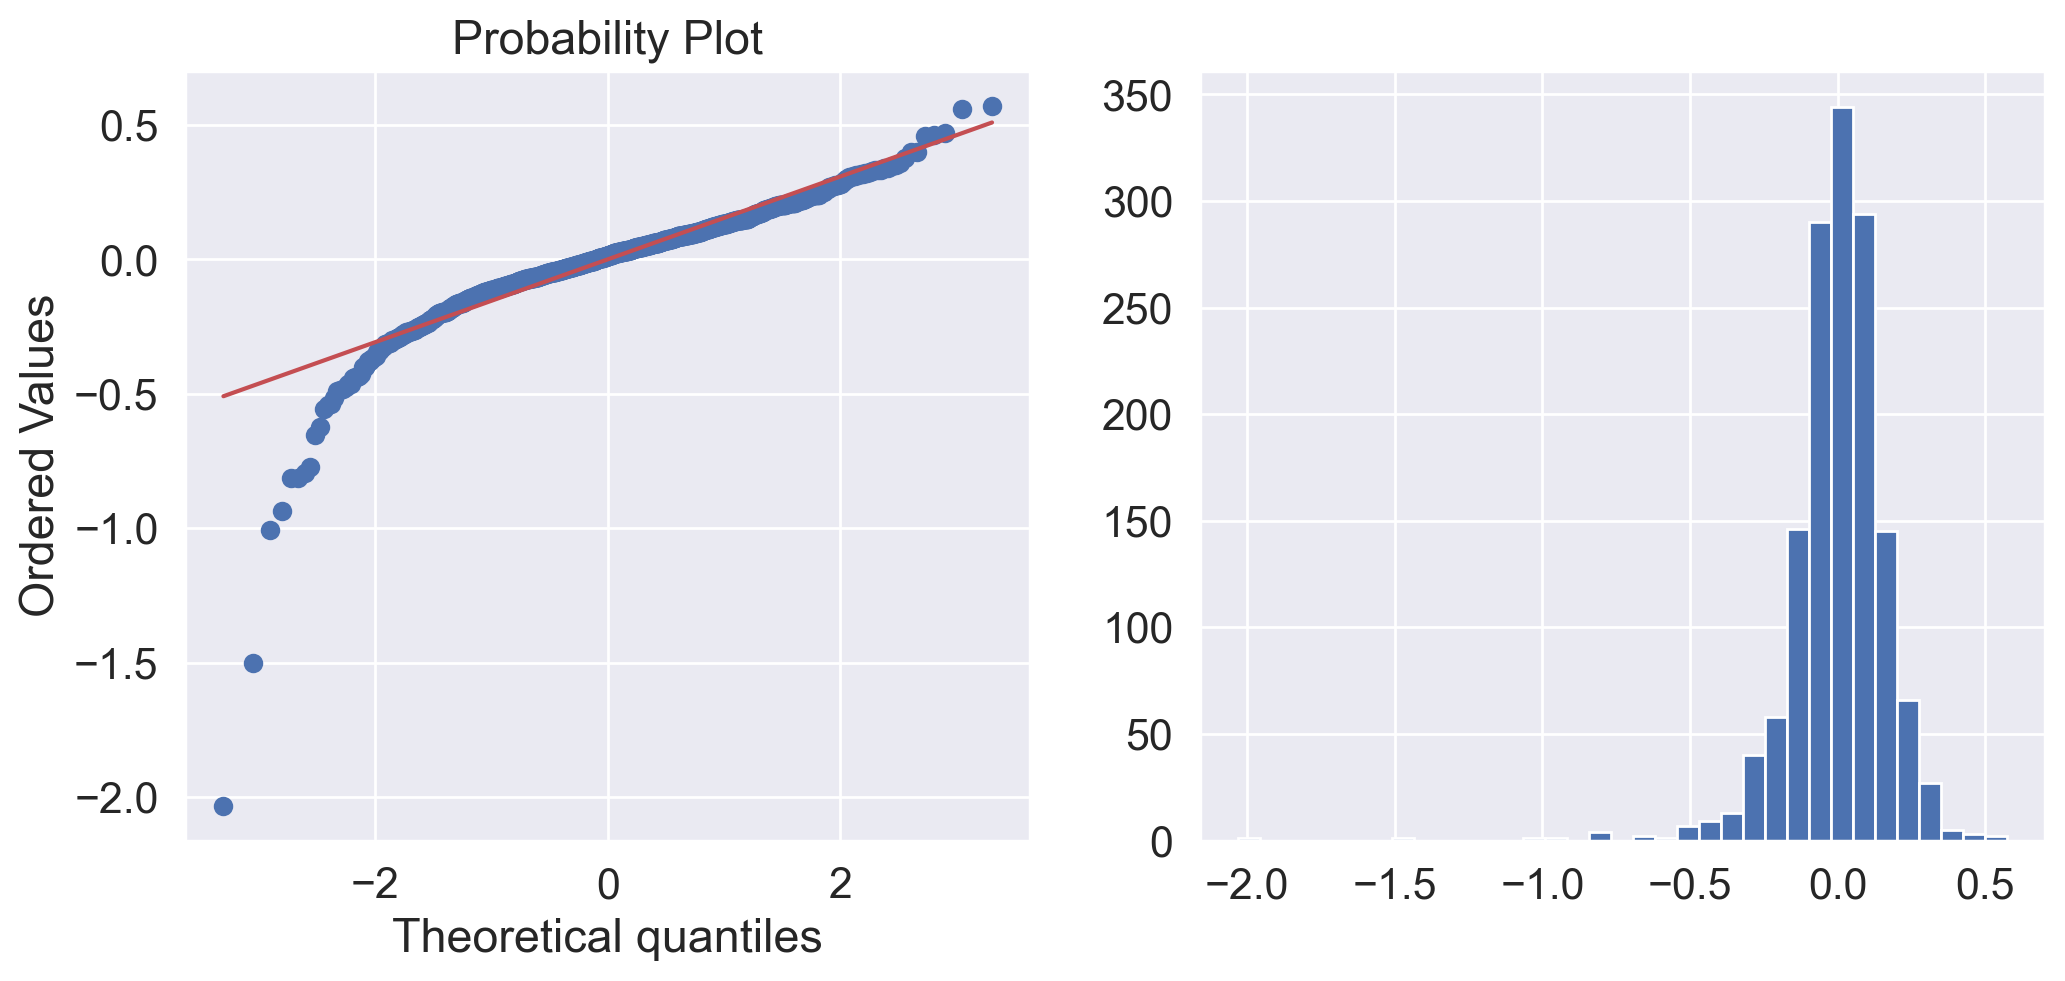

In [58]:
log_resid = np.array(fitted_log_model.resid)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize = [12, 5])
    sps.probplot(log_resid, dist=sps.norm(loc = 0, scale = 1), plot = axes[0])
    plt.hist(log_resid, bins = 35)


Как вы считаете, стоит ли предсказывать логарифм от цены? В каких случаях это полезно?

**Ответ:** после лолгарифмирования основная часть выборки под действием логарифма отобразилась плотнее к лево стороне, что привело к перевешиванию левого хвоста. Возможно такой метод поможет нам когда в правой часте выборка будет плотнее, после чего логорифм сможет сделать нашу выборку симметричной(в каком-то смысле)

## Бонусная часть (20 баллов)

Подойдём к задаче регрессии с байесовской точки зрения. Полезно изучить разделы 8.1, 8.2 конспекта Д.П.Вектрова (https://vk.com/doc126754362_500465695?hash=uU7RYUtCmrntB7ynduiZlYgZuR5C4oSnXqB5nXW0DEk&dl=votNcsozZKYk4ZLO546dYTZd17B3eHok2xSVQP6F6ic)

Только в начале дочитайте задание, а потом лезьте в конспект.

Мы Вам предлагаем увидеть, как при помощи байесовского подхода выбрать важные признаки регрессионной модели. Рекомендуем проделать выкладки без "подглядывания" в конспект.

1) Запишите байесовскую постановку задачи регрессии. Не забудьте про априорное распределение -- регуляризацию (пусть она для всех компонент одинаковая). Регуляризовать будем нормальным распределением, более того считать его компоненты независимыми (матрица ковариаций будет диагональна)

2) Каким будет аналитическое решение, если бы мы реализовывали "байес для бедных"? Какую роль играет регуляризация?

3) Теперь, когда Вы выяснили роль регуляризации давайте вместо диагональной матрицы с одинаковыми значениями на диагонали в качестве априорного распределения возьмём разные значения. Как изменится решение? Что произойдёт с теми признаками, у которых априорная дисперсия высокая? А низкая?

4) В вариационном байесовском выводе у Вас появился интересный объект в знаменателе -- интеграл по всему пространству параметров от регуляризированного правдоподобия. Это называется *обоснованностью* параметрической модели. Чем она выше -- тем лучше заданное семейство распределений описывает Ваши данные.

Прочитайте статью на википедии о бритве Оккама и критерии фальсифицируемости Поппера и ещё раз посмотрите на знаменатель. Порассуждайте о том, почему более обоснованные модели выше.

**Ваш философский ответ:**

А теперь откройте главу 8 конспекта Ветрова и изучите алгоритм максимизации обоснованности.

Напишите его.

Изучите дисперсии, которые получатся после 30 итераций (или сколько Вам понадобится для сходимости). Подумайте, почему алгоритм счёл одни признаки полезнее других. Визуализируйте распределение признака и его дисперсию. Сделайте выводы.

**Вывод:**